# google colab stuff

In [1]:
!git clone https://github.com/sofiyabogakovskaya/HopfieldAM.git

Cloning into 'HopfieldAM'...
remote: Enumerating objects: 496, done.
remote: Counting objects: 100% (147/147), done.
remote: Compressing objects: 100% (106/106), done.
remote: Total 496 (delta 67), reused 107 (delta 35), pack-reused 349 (from 1)
Receiving objects: 100% (496/496), 4.20 MiB | 9.67 MiB/s, done.
Resolving deltas: 100% (252/252), done.


In [ ]:
%%bash
git config --global user.name "sofiyabogakovskaya"
git config --global user.email "s.bogakovskaya@gmail.com"

In [2]:
!pip install -r HopfieldAM/requirements.txt
# !pip install -r requirements.txt

!pip install rootutils

!touch /content/HopfieldAM/.project-root

import os
import rootutils

rootutils.setup_root(os.path.abspath('/content/HopfieldAM'), indicator=".project-root", pythonpath=True, dotenv=True, cwd=True)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.2/193.2 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.0/68.0 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.4/97.4 kB 11.6 MB/s eta 0:00:00


PosixPath('/content/HopfieldAM')

# Start

In [3]:
import os
import shutil
import rootutils
from argparse import Namespace

from typing import Callable, Optional, Tuple, Dict

import pandas as pd
import matplotlib.pyplot as plt

import jax.numpy as jnp
import jax.random as random
from jax import vmap, jit, jvp
from jax import lax
import equinox as eqx
import optax
import diffrax

import numpy as np


# import tensorflow_datasets as tfds

from IPython.display import HTML

In [4]:
rootutils.setup_root(
    search_from=os.getcwd(),   # starts from /home/name/HopfieldAM/notebooks
    indicator=".project-root",
    pythonpath=True,
    dotenv=True,
    cwd=True,
)

PosixPath('/home/s.bogakovskaya/HopfieldAM')

In [6]:
from utils.config import CONFIG
from utils.activation_map import ACTIVATION_MAP
from models import get_model
from losses import get_batch_loss
# from datasets.dataset_loader import get_dataloader
# from datasets.get_dimension import get_dimension
from src.train import train
from src.test import test
# from utils.visualization import plot_metrics, plot_energy, plot_energy_dot, create_batch_to_compute_energy
from utils.integrate_trajectory import integrate_trajectory, get_energy
from utils.logger import new_run_id, log_experiment, log_summary
from utils.parse_config import parse_config
# from utils.for_inference import get_best_checkpoint_path, load_best_model

from utils.trajectory_length import trajectory_direction, trajectory_length
# from utils.create_custom_batch import create_custom_batch
from utils.trajectory_curvature import derivative_based_curvature
from utils.create_gif import create_gif

from tqdm.auto import tqdm
import os
import glob
import re

---
# model of choice - tanh

In [7]:
def load_best_model(args: Namespace, key, checkpoint_path):    
    N_neurons = 784
    g = ACTIVATION_MAP[args.activation]

    model = get_model(args.model, key=key, N_neurons=N_neurons, g=g)
    model = eqx.tree_deserialise_leaves(checkpoint_path, like=model)
    return model

In [8]:
key = random.PRNGKey(19)

checkpoint_path = '/home/s.bogakovskaya/HopfieldAM/notebooks/tanh_lr1e-4_t115.0_dt0.01/best_model_acc_0.9536_ep_19.eqx'

args = Namespace(
    model="Hopfield",
    loss="loss_last10",
    dataset_name = "mnist",
    batch_size=128,
    activation = "tanh",
    dt=0.01,
    t1=15.0,
    N_classes=10,
)

best_model = load_best_model(args, key=key, checkpoint_path=checkpoint_path)

---
# restore stationary states

In [9]:
def find_fixed_point(W, b, x0, max_iters=5000, eps=1e-5):
    """
    Solve x = W tanh(x) + b using fixed-point iteration.

    GUARANTEE:
      - If convergence was achieved (norm < eps), return solution.
      - If not, raise RuntimeError.
    """

    W = jnp.asarray(W, dtype=jnp.float32)
    b = jnp.asarray(b, dtype=jnp.float32)
    x0 = jnp.asarray(x0, dtype=jnp.float32)

    def F(x):
        return W @ jnp.tanh(x) + b

    def body_fun(val):
        i, x, x_prev = val
        x_new = F(x)
        return (i + 1, x_new, x)

    def cond_fun(val):
        i, x, x_prev = val
        return jnp.logical_and(i < max_iters,
                               jnp.linalg.norm(x - x_prev) > eps)

    init_val = (
        jnp.array(0, dtype=jnp.int32),
        x0,
        x0 + jnp.array(10.0, dtype=jnp.float32)
    )

    iters, x_final, x_prev_final = lax.while_loop(cond_fun, body_fun, init_val)

    # strict convergence check
    converged = jnp.linalg.norm(x_final - x_prev_final) <= eps

    if not bool(converged):
        raise RuntimeError(
            f"Fixed-point iteration did NOT converge to eps={eps}. "
            f"Last norm={float(jnp.linalg.norm(x_final - x_prev_final))}, "
            f"iterations={int(iters)}"
        )

    return x_final


In [10]:
def show_image(vec):
    img = vec.reshape(28, 28)
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    plt.show()

In [11]:
from pathlib import Path

In [12]:
def load_idx_images(path):
    with open(path, "rb") as f:
        magic, num, rows, cols = np.frombuffer(f.read(16), dtype=">i4")
        data = np.frombuffer(f.read(), dtype=np.uint8)
        return data.reshape(num, rows * cols)  # flatten


def load_idx_labels(path):
    with open(path, "rb") as f:
        magic, num = np.frombuffer(f.read(8), dtype=">i4")
        return np.frombuffer(f.read(), dtype=np.uint8)

In [13]:
def create_custom_batch(key,
                        numbers: list, 
                        each_number_samples: int, 
                        dataset_name='mnist', 
                        split='test'):
    # archive_path='archive'
    archive_path = Path('/home/s.bogakovskaya/HopfieldAM/notebooks/archive')
    archive_path = Path(archive_path)

    images = load_idx_images(archive_path / "t10k-images.idx3-ubyte")
    labels = load_idx_labels(archive_path / "t10k-labels.idx1-ubyte")
    
    selected_images = []
    selected_labels = []
    
    # we'll split the key for each sampling + one more for final shuffle
    # create enough subkeys: one per requested number, plus one for the final permutation
    n_subkeys = len(numbers) + 1
    keys = random.split(key, n_subkeys)
    subkey_iter = iter(keys[:-1])
    final_shuffle_key = keys[-1]

    for number in numbers:
        # find indices for current number
        mask = labels == number
        indices = jnp.where(mask)[0]
        
        if len(indices) == 0:
            raise ValueError(f'Number {number} not found in {split} split')
        
        # sample with replacement if needed
        replace = indices.shape[0] < each_number_samples
        sk = next(subkey_iter)

        # random.choice accepts a 1-D array of candidates
        selected_indices = random.choice(sk, indices, shape=(each_number_samples,), replace=replace)
        selected_images.append(images[selected_indices])
        selected_labels.append(labels[selected_indices])
    
    # combine and shuffle
    combined_images = jnp.concatenate(selected_images, axis=0)
    combined_labels = jnp.concatenate(selected_labels, axis=0)
    
    shuffle_idx = random.permutation(final_shuffle_key, combined_images.shape[0])
    
    X = combined_images[shuffle_idx].squeeze()
    X = X.reshape(X.shape[0], -1)
    y = combined_labels[shuffle_idx]  
    return X, y

In [14]:
X, y = create_custom_batch(key,
                    numbers = [0],
                    each_number_samples=10)

In [15]:
x0 = X[1]

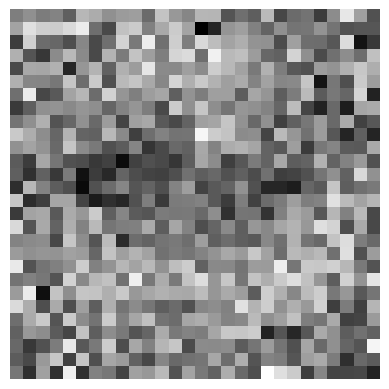

In [16]:
x_final = find_fixed_point(best_model.W, best_model.b, x0)
show_image(x_final)

In [17]:
def L2_norm(x, y):
  return jnp.sqrt(jnp.sum((x - y) ** 2))

def L1_norm(x, y):
    return jnp.sum(jnp.abs(x - y))

samples for 0


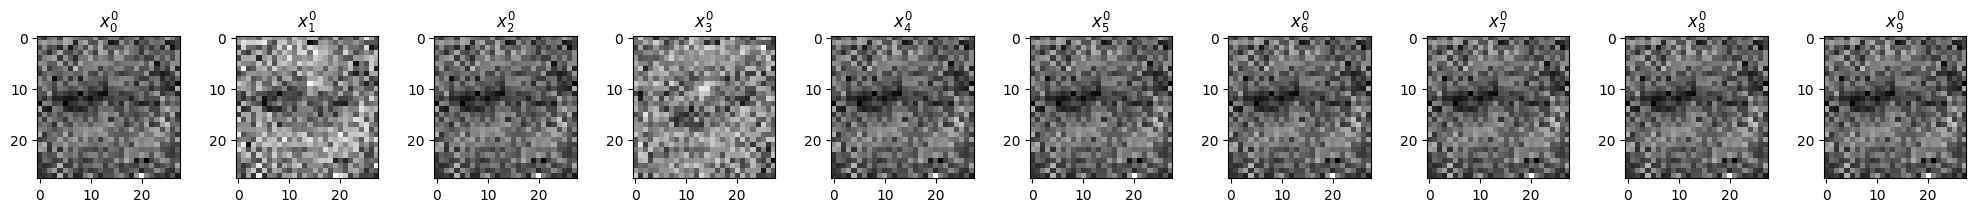

samples for 1


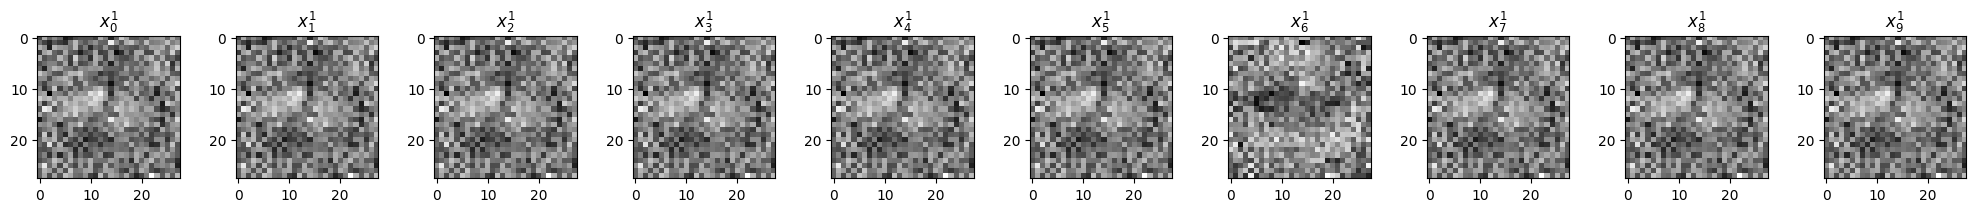

samples for 2


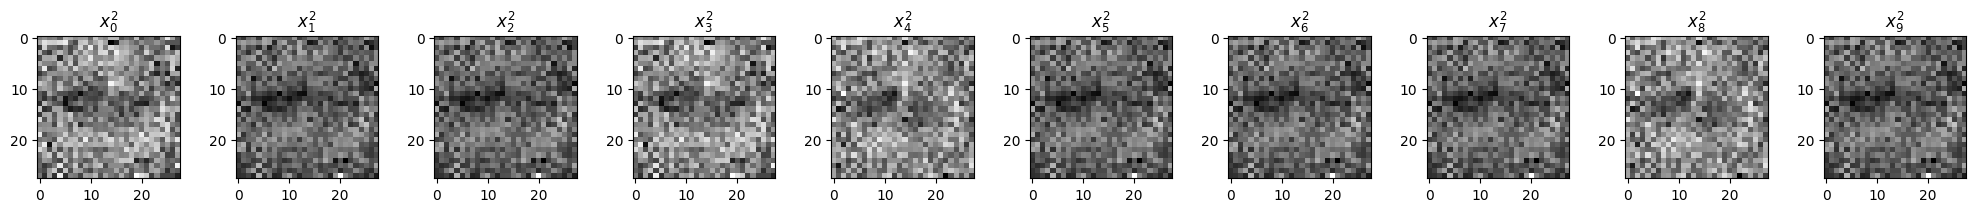

samples for 3


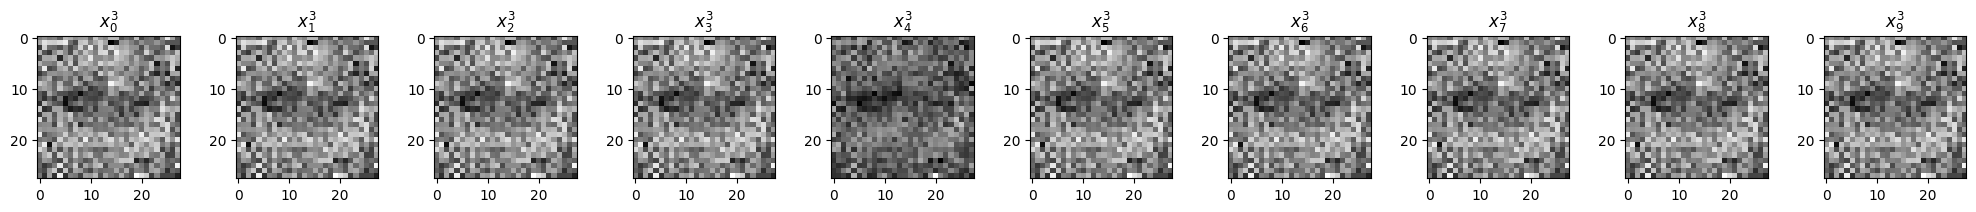

samples for 4


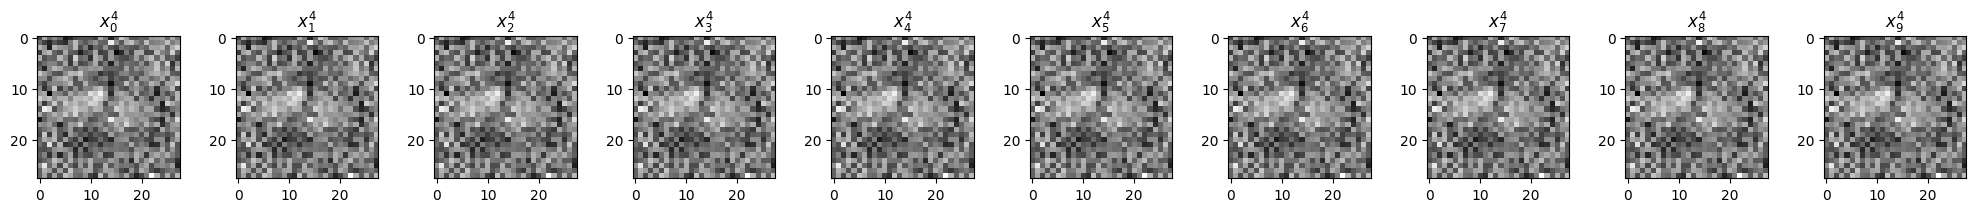

samples for 5


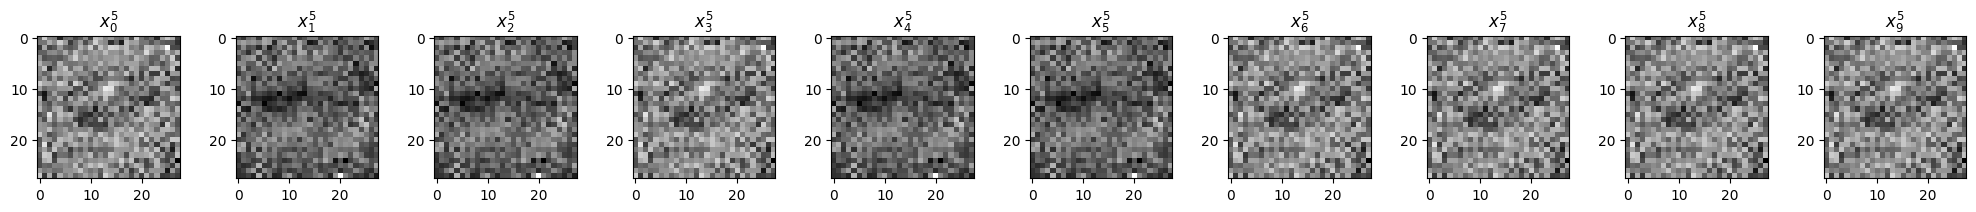

samples for 6


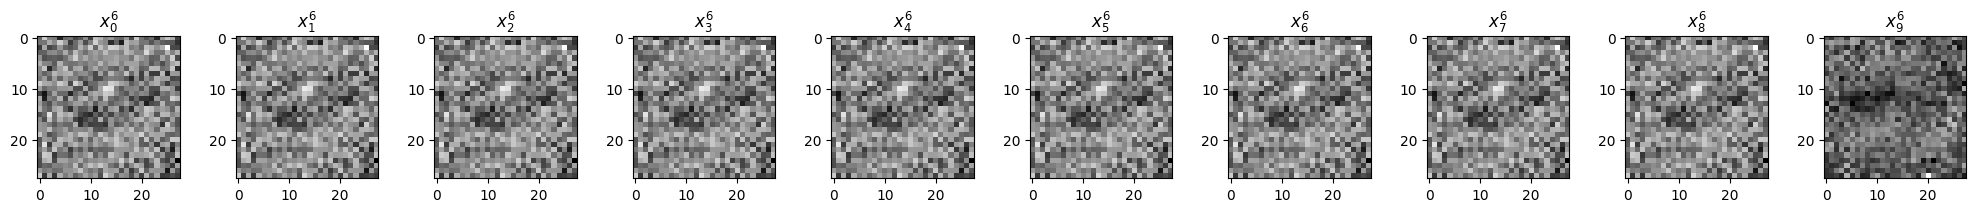

samples for 7


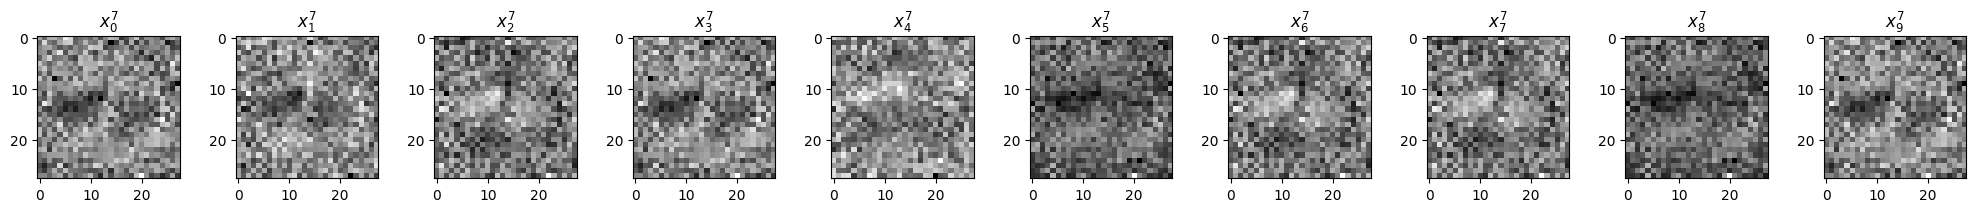

samples for 8


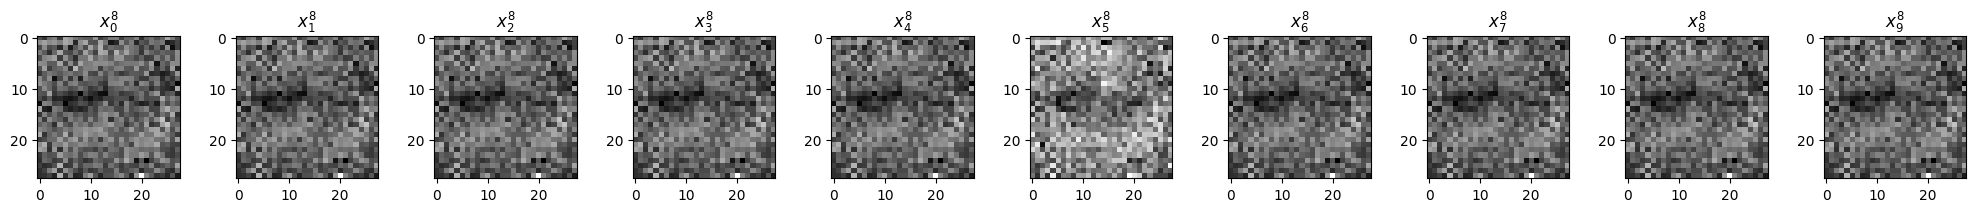

samples for 9


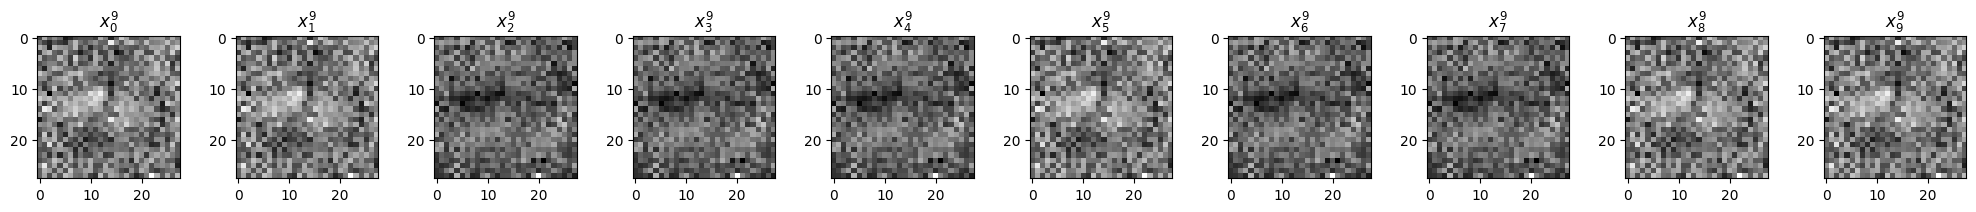

In [18]:
all_samples = []
averages = []
num_samples = 10

for i in range(10):
    fig = plt.figure(figsize=(num_samples*2, 2))
    print(f"samples for {i}")
    X, y = create_custom_batch(key,
                      numbers = [i],
                      each_number_samples=num_samples)
    row=[]
    for j in range(num_samples):
        ax = fig.add_subplot(1, num_samples, j+1)
        plt.sca(ax)
        ax.set_title(f"$x_{j}^{i}$")
        x0 = X[j].astype(jnp.float32)
        x_final = find_fixed_point(best_model.W, best_model.b, x0, max_iters=10000, eps=1e-05)
        row.append(x_final)
        img = x_final.reshape(28, 28)
        plt.imshow(img, cmap="gray")

    all_samples.append(row)

    row_stack = jnp.stack(row, axis=0)  # shape (10, N)
    row_mean = jnp.mean(row_stack, axis=0)  # shape (N,)
    averages.append(row_mean)

    plt.tight_layout()
    plt.show()

In [19]:
dists_within_class = []
for i in range(10):
  x_0 = all_samples[i][0]
  row = []
  for j in range(num_samples):
      dist = L2_norm(x_0, all_samples[i][j])
      row.append(dist)
  dists_within_class.append(row)

dists_within_class_df = pd.DataFrame(dists_within_class, columns=[str(i) for i in range(10)])
dists_within_class_df

,0,1,2,3,4,5,6,7,8,9
0,0.0,34.474606,1.2205688e-05,66.94833,1.0501724e-05,6.2966533e-06,1.3229848e-05,2.1452093e-05,1.966475e-05,4.949945e-06
1,0.0,4.5986803e-06,6.787618e-06,5.5119344e-06,0.00017889921,6.4403494e-06,97.86926,4.7966173e-06,5.1105226e-06,6.858659e-06
2,0.0,34.474613,34.474613,6.9024954e-06,44.117386,34.47462,34.474613,34.474613,44.117386,34.474663
3,0.0,4.5253e-06,0.00028831043,6.310202e-06,34.474476,0.00027714545,0.0002767,4.1762946e-06,1.0922574e-05,0.00016226171
4,0.0,0.00018766367,1.6001037e-05,0.00017428795,0.00018962575,1.1242057e-05,1.0858219e-05,0.00017254862,8.818753e-06,6.0641596e-06
5,0.0,66.94833,66.94833,1.8819786e-05,66.94833,66.94833,7.988725e-06,1.7223636e-05,4.9440987e-06,1.0743513e-05
6,0.0,2.3708333e-05,2.0656817e-05,2.070009e-05,2.8981647e-05,2.568565e-05,2.01341e-05,2.9654524e-05,0.00036352698,66.94834
7,0.0,47.97387,95.753914,4.65112e-06,82.69815,39.794422,95.753944,95.753944,39.794426,7.904926e-06
8,0.0,8.911243e-06,6.429363e-06,8.906096e-06,4.7432527e-06,34.474472,4.798081e-06,1.1082979e-05,8.720388e-06,1.9322963e-05
9,0.0,6.603875e-06,94.478966,94.478966,94.478966,5.2766995e-06,94.478966,94.478966,0.00017690046,7.84677e-06


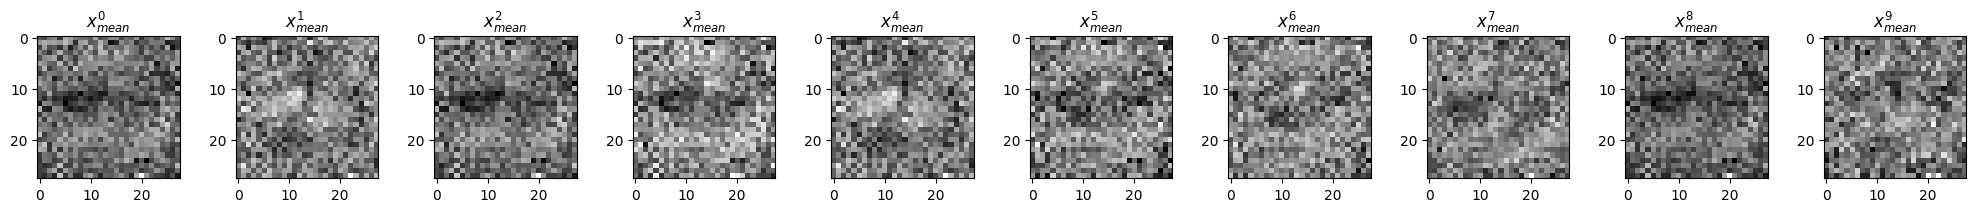

In [20]:
fig = plt.figure(figsize=(10*2, 2))
for i in range(10):
    ax = fig.add_subplot(1, 10, i+1)
    plt.sca(ax)
    ax.set_title(f"$x_{{mean}}^{i}$")
    img = averages[i].reshape(28, 28)
    plt.imshow(img, cmap="gray")

plt.tight_layout()
plt.show()

In [21]:
x_0 = averages[4]
distances_between_classes = []
for i in range(10):
    x_0 = averages[i]
    row = []
    for j in range(10):
        dist = L2_norm(x_0, averages[j])
        row.append(dist)
    distances_between_classes.append(row)

distances_between_classes_df = pd.DataFrame(distances_between_classes, columns=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
distances_between_classes_df

,0,1,2,3,4,5,6,7,8,9
0,0.0,81.60868,11.106529,23.4815,90.98145,31.202682,51.247852,39.049877,6.6948466,44.175507
1,81.60868,0.0,85.56898,87.20511,9.7869215,70.87058,71.40655,51.809082,85.031105,38.23018
2,11.106529,85.56898,0.0,20.442368,95.03439,34.255756,53.41824,39.645508,12.6123295,49.000404
3,23.4815,87.20511,20.442368,0.0,96.985664,29.346561,44.951694,46.26233,27.579628,54.340405
4,90.98145,9.7869215,95.03439,96.985664,0.0,80.24301,80.03393,60.71034,94.25777,47.2395
5,31.202682,70.87058,34.255756,29.346561,80.24301,0.0,20.08452,37.486057,37.87978,42.363613
6,51.247852,71.40655,53.41824,44.951694,80.03393,20.08452,0.0,48.88821,57.935635,52.786263
7,39.049877,51.809082,39.645508,46.26233,60.71034,37.486057,48.88821,0.0,42.336052,23.220991
8,6.6948466,85.031105,12.6123295,27.579628,94.25777,37.87978,57.935635,42.336052,0.0,47.081158
9,44.175507,38.23018,49.000404,54.340405,47.2395,42.363613,52.786263,23.220991,47.081158,0.0


---
# model of choice -- Tanh, t1 = 5.0

In [53]:
experiments_dir = "/content/drive/MyDrive/HopfieldAM_experiments/experiments_lr_e-4"

key = random.PRNGKey(19)

args = Namespace(
    model="Hopfield",
    loss="loss_last10",
    dataset_name = "mnist",
    batch_size=128,
    activation = "tanh",
    dt=0.01,
    t1=5.0,
    N_classes=10,
)

best_model = load_best_model(
    args,
    experiments_dir=experiments_dir
  )

TypeError: load_best_model() got an unexpected keyword argument 'experiments_dir'

samples for 0


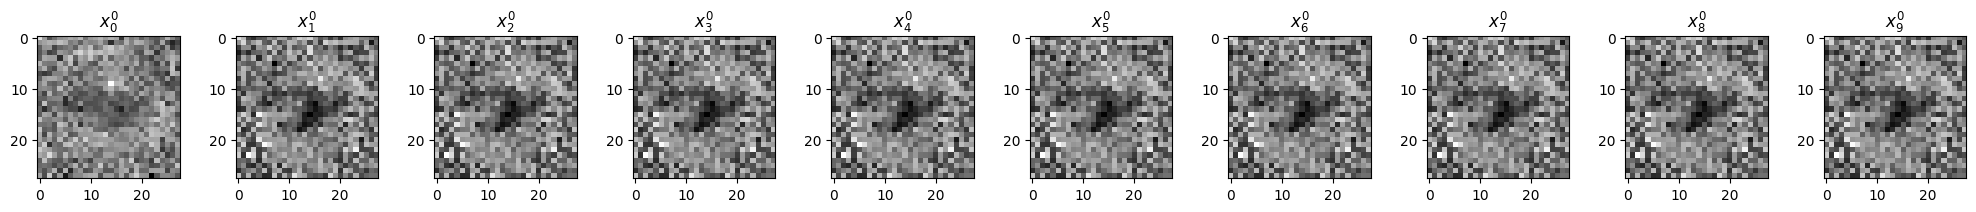

samples for 1


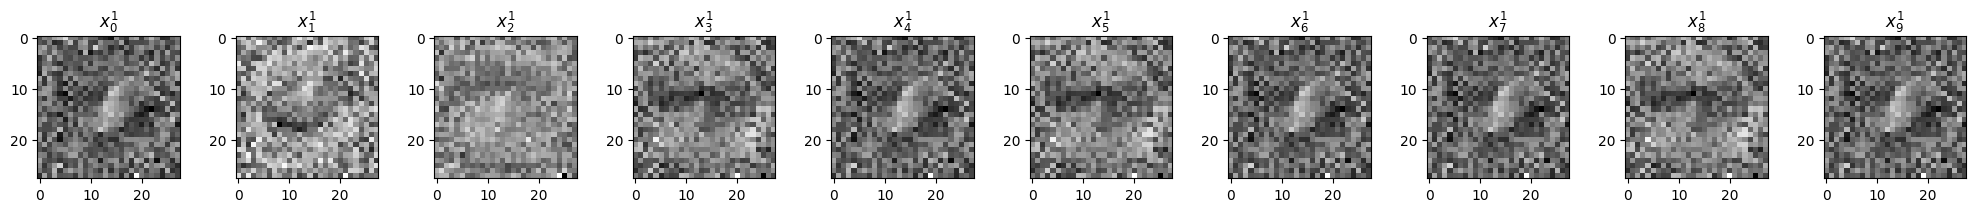

samples for 2


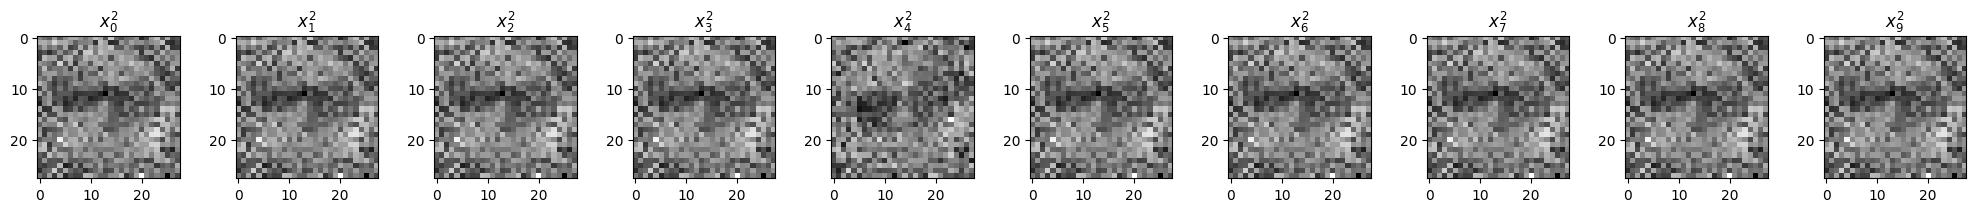

samples for 3


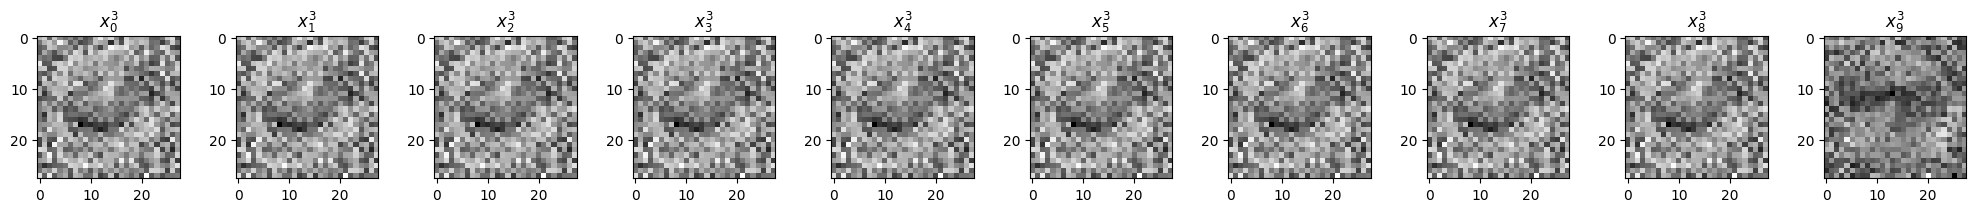

samples for 4


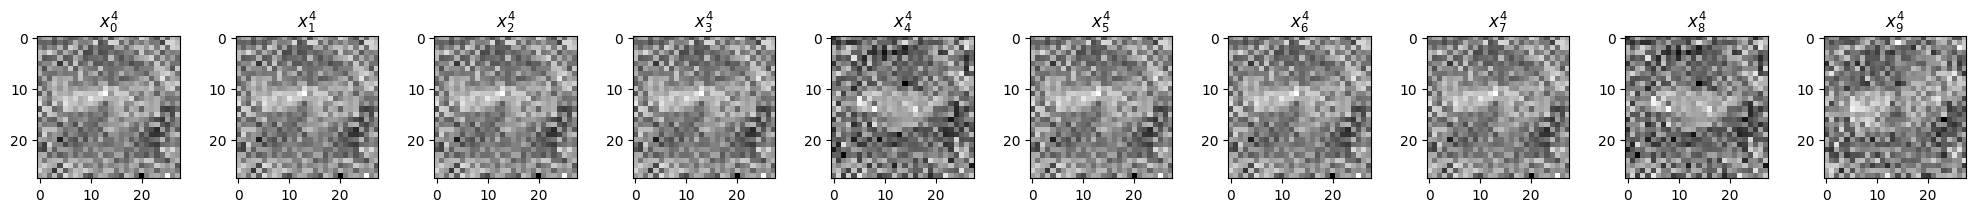

samples for 5


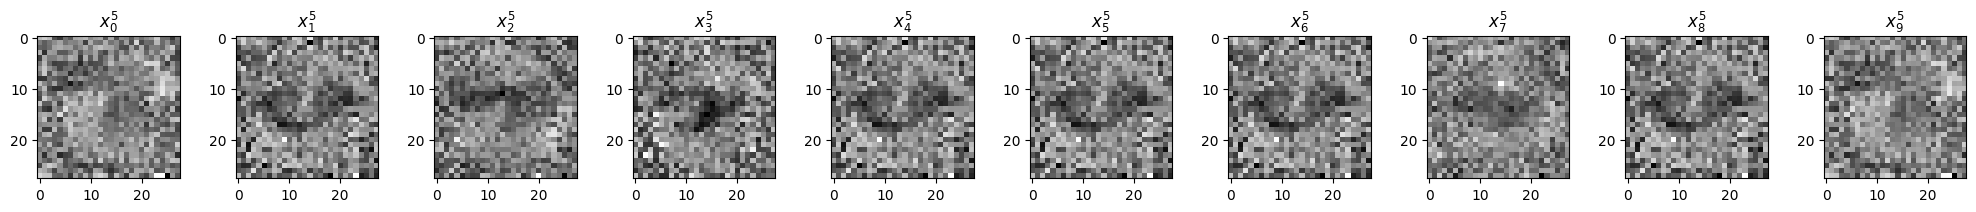

samples for 6


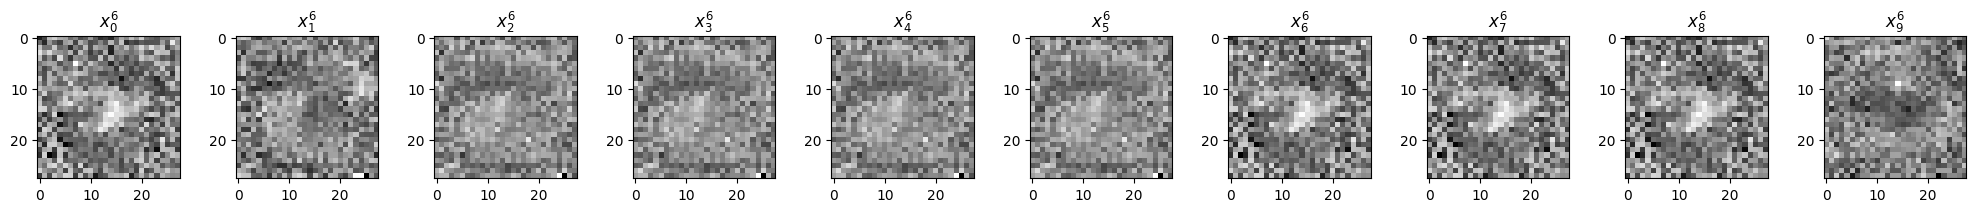

samples for 7


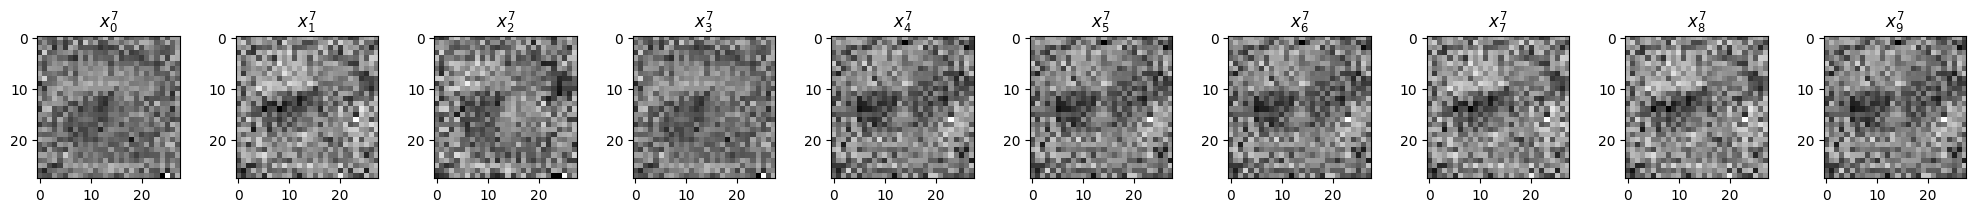

samples for 8


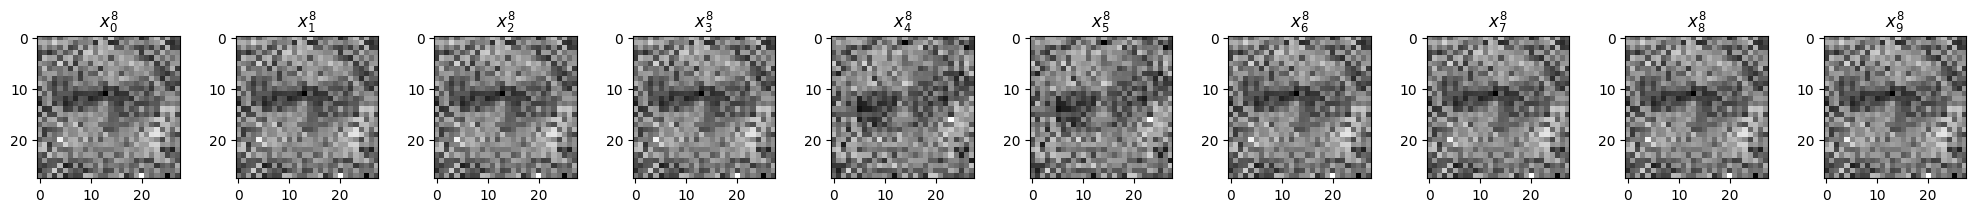

samples for 9


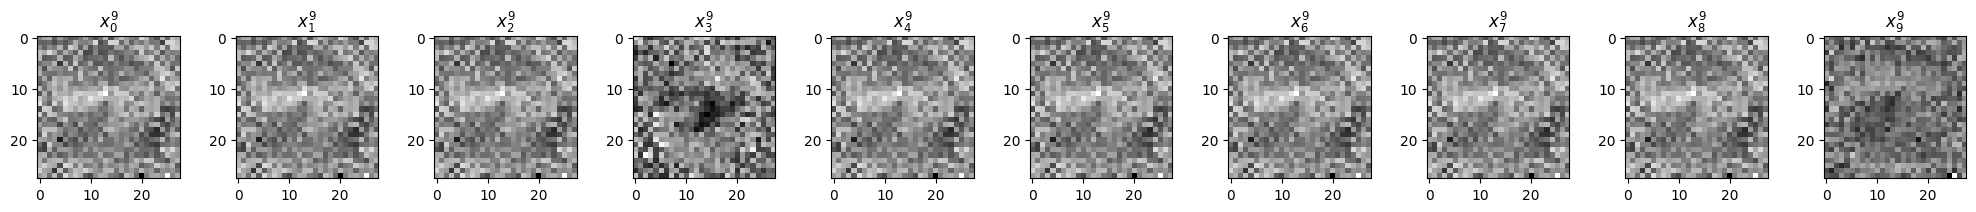

In [17]:
all_samples = []
averages = []
num_samples = 10

for i in range(10):
    fig = plt.figure(figsize=(num_samples*2, 2))
    print(f"samples for {i}")
    X, y = create_custom_batch(key,
                      numbers = [i],
                      each_number_samples=num_samples)
    row=[]
    for j in range(num_samples):
        ax = fig.add_subplot(1, num_samples, j+1)
        plt.sca(ax)
        ax.set_title(f"$x_{j}^{i}$")
        x0 = X[j].astype(jnp.float32)
        x_final = find_fixed_point(best_model.W, best_model.b, x0, max_iters=10000, eps=1e-05)
        row.append(x_final)
        img = x_final.reshape(28, 28)
        plt.imshow(img, cmap="gray")

    all_samples.append(row)

    row_stack = jnp.stack(row, axis=0)  # shape (10, N)
    row_mean = jnp.mean(row_stack, axis=0)  # shape (N,)
    averages.append(row_mean)

    plt.tight_layout()
    plt.show()

In [18]:
dists_within_class = []
for i in range(10):
  x_0 = all_samples[i][0]
  row = []
  for j in range(num_samples):
      dist = L2_norm(x_0, all_samples[i][j])
      row.append(dist)
  dists_within_class.append(row)

dists_within_class_df = pd.DataFrame(dists_within_class, columns=[str(i) for i in range(10)])
dists_within_class_df

,0,1,2,3,4,5,6,7,8,9
0,0.0,71.952835,71.95283,71.95283,71.95283,71.95283,71.952835,71.95283,71.95283,71.95283
1,0.0,129.07092,103.10622,108.61003,0.00011425493,108.61003,0.00011519942,0.00011805984,108.61003,0.000112996524
2,0.0,1.142793e-05,7.446206e-06,6.866869e-06,71.1248,5.330582e-06,1.159926e-05,5.7176253e-06,5.986397e-06,0.00016829334
3,0.0,9.698561e-06,1.3793277e-05,7.794931e-06,9.910552e-06,6.055617e-06,9.415085e-06,1.1138266e-05,9.479001e-06,101.0983
4,0.0,5.8256583e-06,8.907234e-06,7.689035e-06,68.99235,6.717606e-06,9.159091e-06,5.7672737e-06,68.9924,67.4158
5,0.0,108.68798,109.29719,96.06768,108.68798,108.68798,108.68798,112.953064,108.68798,6.2457198e-06
6,0.0,124.27585,101.8044,101.80435,101.8044,101.8044,6.4989226e-06,8.614753e-06,6.6023244e-06,140.95285
7,0.0,71.64437,68.69687,0.00015321649,103.89713,103.89713,103.89713,71.64436,71.64437,103.89713
8,0.0,1.3597244e-05,8.391497e-06,1.2614051e-05,71.12482,71.1248,1.077148e-05,7.5060448e-06,7.854008e-06,1.3800167e-05
9,0.0,1.0674258e-05,1.8982582e-05,129.4084,1.0185551e-05,1.1800732e-05,1.0047784e-05,1.5424985e-05,1.0945816e-05,95.93234


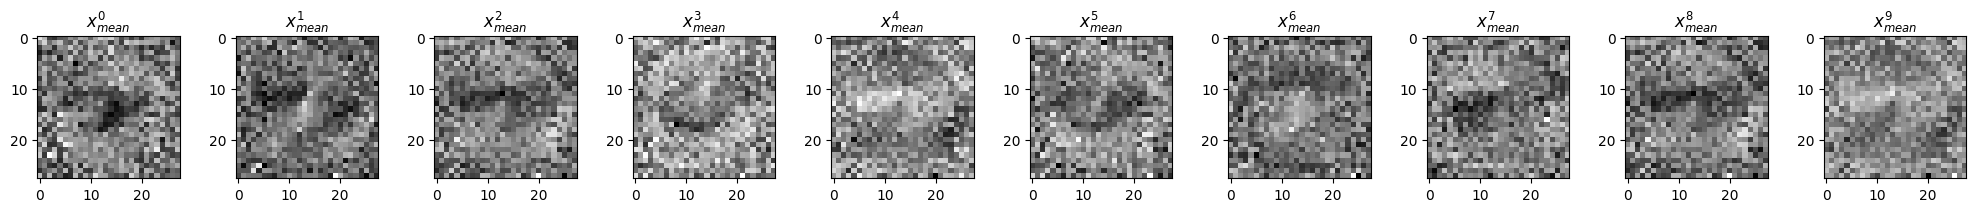

In [19]:
fig = plt.figure(figsize=(10*2, 2))
for i in range(10):
    ax = fig.add_subplot(1, 10, i+1)
    plt.sca(ax)
    ax.set_title(f"$x_{{mean}}^{i}$")
    img = averages[i].reshape(28, 28)
    plt.imshow(img, cmap="gray")

plt.tight_layout()
plt.show()

In [20]:
x_0 = averages[4]
distances_between_classes = []
for i in range(10):
    x_0 = averages[i]
    row = []
    for j in range(10):
        dist = L2_norm(x_0, averages[j])
        row.append(dist)
    distances_between_classes.append(row)

distances_between_classes_df = pd.DataFrame(distances_between_classes, columns=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
distances_between_classes_df

,0,1,2,3,4,5,6,7,8,9
0,0.0,88.14411,76.993004,85.42402,126.54575,52.61532,111.21246,88.91429,76.82034,109.97255
1,88.14411,0.0,60.79922,86.01494,107.375626,58.17738,55.560654,77.10138,59.19562,103.05219
2,76.993004,60.79922,0.0,86.082,148.12755,58.443188,91.68899,76.27388,7.1124864,138.76013
3,85.42402,86.01494,86.082,0.0,119.9941,61.568165,91.67351,71.25322,81.5015,106.14139
4,126.54575,107.375626,148.12755,119.9941,0.0,115.762505,83.63502,120.41105,146.05873,25.667341
5,52.61532,58.17738,58.443188,61.568165,115.762505,0.0,77.92243,77.59247,56.43208,103.91388
6,111.21246,55.560654,91.68899,91.67351,83.63502,77.92243,0.0,98.841484,90.27763,87.13481
7,88.91429,77.10138,76.27388,71.25322,120.41105,77.59247,98.841484,0.0,70.40002,104.38933
8,76.82034,59.19562,7.1124864,81.5015,146.05873,56.43208,90.27763,70.40002,0.0,136.11557
9,109.97255,103.05219,138.76013,106.14139,25.667341,103.91388,87.13481,104.38933,136.11557,0.0


---
# model of choice -- ReLU

In [ ]:
experiments_dir = "/content/drive/MyDrive/HopfieldAM_experiments/experiments_lr_e-3"

key = random.PRNGKey(19)

args = Namespace(
    model="Hopfield",
    loss="loss_last10",
    dataset_name = "mnist",
    batch_size=128,
    activation = "relu",
    dt=0.01,
    t1=15.0,
    N_classes=10,
)

best_model = load_best_model(
    args,
    experiments_dir=experiments_dir
  )

In [ ]:
def find_fixed_point(W, b, x0, max_iters=5000, eps=1e-5):
    """
    Solve x = W tanh(x) + b using fixed-point iteration.

    GUARANTEE:
      - If convergence was achieved (norm < eps), return solution.
      - If not, raise RuntimeError.
    """

    W = jnp.asarray(W, dtype=jnp.float32)
    b = jnp.asarray(b, dtype=jnp.float32)
    x0 = jnp.asarray(x0, dtype=jnp.float32)

    def relu(x):
        return (x if x > 0 else 0)

    def F(x):
        return W @ relu(x) + b

    def body_fun(val):
        i, x, x_prev = val
        x_new = F(x)
        return (i + 1, x_new, x)

    def cond_fun(val):
        i, x, x_prev = val
        return jnp.logical_and(i < max_iters,
                               jnp.linalg.norm(x - x_prev) > eps)

    init_val = (
        jnp.array(0, dtype=jnp.int32),
        x0,
        x0 + jnp.array(10.0, dtype=jnp.float32)
    )

    iters, x_final, x_prev_final = lax.while_loop(cond_fun, body_fun, init_val)

    # strict convergence check
    converged = jnp.linalg.norm(x_final - x_prev_final) <= eps

    if not bool(converged):
        raise RuntimeError(
            f"Fixed-point iteration did NOT converge to eps={eps}. "
            f"Last norm={float(jnp.linalg.norm(x_final - x_prev_final))}, "
            f"iterations={int(iters)}"
        )

    return x_final

In [ ]:
def show_image(vec):
    img = vec.reshape(28, 28)
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    plt.show()

samples for 0


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

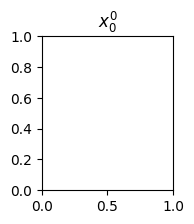

In [ ]:
all_samples = []
averages = []
num_samples = 10

for i in range(10):
    fig = plt.figure(figsize=(num_samples*2, 2))
    print(f"samples for {i}")
    X, y = create_custom_batch(key,
                      numbers = [i],
                      each_number_samples=num_samples)
    row=[]
    for j in range(num_samples):
        ax = fig.add_subplot(1, num_samples, j+1)
        plt.sca(ax)
        ax.set_title(f"$x_{j}^{i}$")
        x0 = X[j].astype(jnp.float32)
        x_final = find_fixed_point(best_model.W, best_model.b, x0, max_iters=10000, eps=1e-05)
        row.append(x_final)
        img = x_final.reshape(28, 28)
        plt.imshow(img, cmap="gray")

    all_samples.append(row)

    row_stack = jnp.stack(row, axis=0)  # shape (10, N)
    row_mean = jnp.mean(row_stack, axis=0)  # shape (N,)
    averages.append(row_mean)

    plt.tight_layout()
    plt.show()

---
#Compare final state to stock state

## Model of choice: tanh, t1 = 15.0

In [22]:
experiments_dir = "/content/drive/MyDrive/HopfieldAM_experiments/experiments_lr_e-4"

key = random.PRNGKey(19)

args.activation = 'tanh'
args.t1 = 15.0

best_model = load_best_model(
    args,
    experiments_dir=experiments_dir
  )

In [23]:
from utils.integrate import integrate

samples for 0


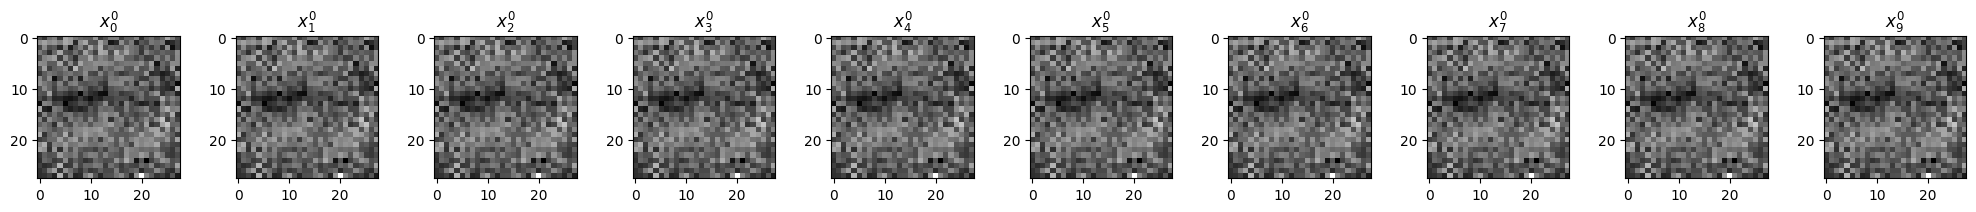

In [33]:
all_samples = []
all_samples1 = []
averages = []
num_samples = 10

for i in range(1):
    fig = plt.figure(figsize=(num_samples*2, 2))
    print(f"samples for {i}")
    X, y = create_custom_batch(key,
                      numbers = [i],
                      each_number_samples=num_samples)
    row=[]
    row1=[]
    for j in range(num_samples):
        ax = fig.add_subplot(1, num_samples, j+1)
        plt.sca(ax)
        ax.set_title(f"$x_{j}^{i}$")
        x0 = X[j].astype(jnp.float32)
        x_stationary = find_fixed_point(best_model.W, best_model.b, x0, max_iters=10000, eps=1e-05)
        x_final = integrate(best_model, x0, args.dt, args.t1)
        row.append(jnp.linalg.norm(x_stationary-x_final))
        row1.append(jnp.linalg.norm(x_stationary))
        img = x_stationary.reshape(28, 28)
        plt.imshow(img, cmap="gray")

    all_samples.append(row)
    all_samples1.append(row1)

    row_stack = jnp.stack(row, axis=0)  # shape (10, N)
    row_mean = jnp.mean(row_stack, axis=0)  # shape (N,)
    averages.append(row_mean)

    plt.tight_layout()
    plt.show()

In [34]:
print(all_samples1)

[[Array(53.91404, dtype=float32), Array(53.91404, dtype=float32), Array(53.91404, dtype=float32), Array(53.914043, dtype=float32), Array(53.91404, dtype=float32), Array(53.91404, dtype=float32), Array(53.91404, dtype=float32), Array(53.91404, dtype=float32), Array(53.91404, dtype=float32), Array(53.91404, dtype=float32)]]


samples for 0


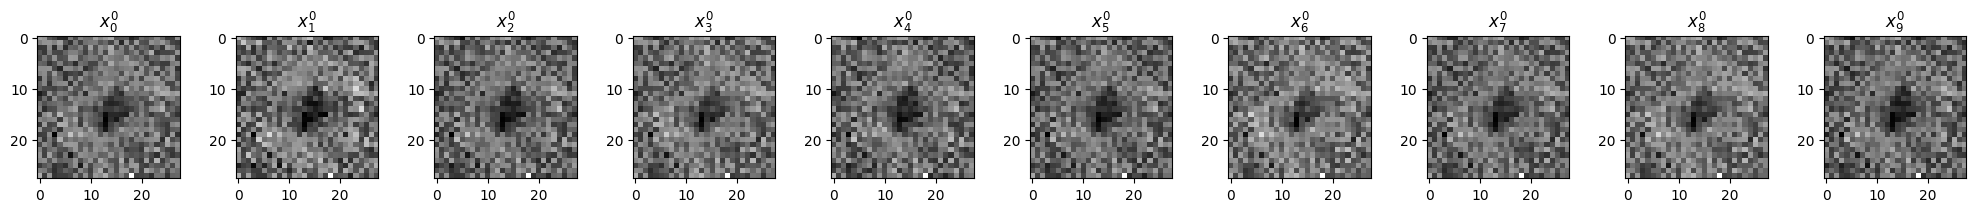

In [35]:
all_samples = []
all_samples1 = []
averages = []
num_samples = 10

for i in range(1):
    fig = plt.figure(figsize=(num_samples*2, 2))
    print(f"samples for {i}")
    X, y = create_custom_batch(key,
                      numbers = [i],
                      each_number_samples=num_samples)
    row=[]
    row1=[]
    for j in range(num_samples):
        ax = fig.add_subplot(1, num_samples, j+1)
        plt.sca(ax)
        ax.set_title(f"$x_{j}^{i}$")
        x0 = X[j].astype(jnp.float32)
        x_stationary = find_fixed_point(best_model.W, best_model.b, x0, max_iters=10000, eps=1e-05)
        x_final = integrate(best_model, x0, args.dt, args.t1)
        row.append(jnp.linalg.norm(x_stationary-x_final))
        row1.append(jnp.linalg.norm(x_stationary))
        img = x_final.reshape(28, 28)
        plt.imshow(img, cmap="gray")

    all_samples.append(row)
    all_samples1.append(row1)

    row_stack = jnp.stack(row, axis=0)  # shape (10, N)
    row_mean = jnp.mean(row_stack, axis=0)  # shape (N,)
    averages.append(row_mean)

    plt.tight_layout()
    plt.show()

---
# Clasterization

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist, squareform
from tqdm.auto import tqdm
import jax.numpy as jnp
from utils.integrate import integrate

In [43]:
def integrate_over_dataset(model, X_0, dt, t1):
    n_samples = X_0.shape[0]
    X_T = np.zeros_like(X_0)
    
    for i in tqdm(range(n_samples), desc="Integrating samples"):
        x0 = jnp.array(X_0[i], dtype=jnp.float32)
        xt = integrate(model, x0, dt, t1)
        X_T[i] = np.array(xt)
    
    return X_T


def standardize(X):
    return (X - X.mean(axis=0)) / (X.std(axis=0) + 1e-8)


def manual_pca(X, n_components=50):
    """Simple PCA without sklearn."""
    X_centered = X - X.mean(axis=0)
    cov_matrix = np.cov(X_centered.T)
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    
    idx = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    X_pca = X_centered @ eigenvectors[:, :n_components]
    explained_var = eigenvalues[:n_components].sum() / eigenvalues.sum()
    
    return X_pca, explained_var


def silhouette_score_manual(X, labels):
    """Calculate silhouette score."""
    unique_labels = np.unique(labels)
    if len(unique_labels) == 1:
        return 0.0
    
    distances = squareform(pdist(X, metric='euclidean'))
    silhouette_vals = []
    
    for i in range(len(labels)):
        label_i = labels[i]
        same_cluster = labels == label_i
        
        if same_cluster.sum() == 1:
            continue
            
        a_i = distances[i, same_cluster].sum() / (same_cluster.sum() - 1)
        
        b_i = np.inf
        for label_j in unique_labels:
            if label_j == label_i:
                continue
            other_cluster = labels == label_j
            if other_cluster.sum() > 0:
                b_ij = distances[i, other_cluster].mean()
                b_i = min(b_i, b_ij)
        
        s_i = (b_i - a_i) / max(a_i, b_i)
        silhouette_vals.append(s_i)
    
    return np.mean(silhouette_vals) if silhouette_vals else 0.0


# Main Clustering Function

def find_subclusters(X_T, y, target_class, n_samples=500):
    """
    Find subclusters within a single digit class.
    
    Args:
        X_T: Integrated states (N, 784)
        y: Labels (N,)
        target_class: Which digit (0-9)
        n_samples: Number of samples
    
    Returns:
        Dictionary with results
    """
    # Select samples
    mask = y == target_class
    X_class = np.array(X_T[mask][:n_samples])
    print(f"\nAnalyzing class {target_class}: {X_class.shape[0]} samples")
    
    # Standardize and reduce dimensions
    X_scaled = standardize(X_class)
    X_50d, explained_var = manual_pca(X_scaled, n_components=50)
    X_2d, _ = manual_pca(X_scaled, n_components=2)
    
    print(f"PCA explained variance (50D): {explained_var:.3f}")
    
    # Hierarchical clustering
    print("\nTesting different numbers of clusters...")
    Z = linkage(X_50d, method='ward')
    
    best_k = 2
    best_score = -1
    all_results = []
    
    for k in range(2, 11):
        labels = fcluster(Z, k, criterion='maxclust') - 1
        score = silhouette_score_manual(X_50d, labels)
        all_results.append((k, score, labels))
        print(f"  k={k}: silhouette={score:.3f}")
        
        if score > best_score:
            best_score = score
            best_k = k
    
    best_labels = [labels for k, score, labels in all_results if k == best_k][0]
    
    print(f"\n✓ Optimal: {best_k} subclusters (silhouette={best_score:.3f})")
    
    return {
        'labels': best_labels,
        'X_2d': X_2d,
        'X_class': X_class,
        'linkage': Z,
        'all_results': all_results,
        'best_k': best_k,
        'best_score': best_score,
        'class': target_class
    }



def visualize_subclusters(results):
    """Visualize clustering results."""
    target_class = results['class']
    
    fig = plt.figure(figsize=(16, 5))
    
    # Plot 1: Dendrogram
    ax1 = plt.subplot(1, 3, 1)
    dendrogram(results['linkage'], truncate_mode='lastp', p=20, 
               show_leaf_counts=True, ax=ax1)
    ax1.set_title(f'Hierarchical Structure - Class {target_class}')
    ax1.set_xlabel('Cluster Index (Sample Count)')
    ax1.set_ylabel('Distance')
    
    # Plot 2: 2D scatter
    ax2 = plt.subplot(1, 3, 2)
    scatter = ax2.scatter(
        results['X_2d'][:, 0],
        results['X_2d'][:, 1],
        c=results['labels'],
        cmap='tab10',
        s=30,
        alpha=0.7,
        edgecolors='k',
        linewidth=0.5
    )
    ax2.set_title(f'{results["best_k"]} Subclusters Found\nClass {target_class}')
    ax2.set_xlabel('PC 1')
    ax2.set_ylabel('PC 2')
    plt.colorbar(scatter, ax=ax2, label='Subcluster')
    
    # Plot 3: Silhouette scores
    ax3 = plt.subplot(1, 3, 3)
    k_values = [r[0] for r in results['all_results']]
    scores = [r[1] for r in results['all_results']]
    ax3.plot(k_values, scores, 'o-', linewidth=2, markersize=8, color='steelblue')
    ax3.axvline(results['best_k'], color='red', linestyle='--', 
                linewidth=2, label=f'Best k={results["best_k"]}')
    ax3.set_xlabel('Number of Clusters (k)')
    ax3.set_ylabel('Silhouette Score')
    ax3.set_title('Cluster Quality vs k')
    ax3.grid(True, alpha=0.3)
    ax3.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Show representative images
    n_clusters = results['best_k']
    fig, axes = plt.subplots(2, min(n_clusters, 5), figsize=(3*min(n_clusters, 5), 6))
    
    if n_clusters == 1:
        axes = axes.reshape(-1, 1)
    elif min(n_clusters, 5) == 1:
        axes = axes.reshape(-1, 1)
    
    for cluster_id in range(min(n_clusters, 5)):
        cluster_mask = results['labels'] == cluster_id
        n_in_cluster = cluster_mask.sum()
        
        if n_in_cluster > 0:
            # Average
            avg_image = results['X_class'][cluster_mask].mean(axis=0).reshape(28, 28)
            axes[0, cluster_id].imshow(avg_image, cmap='gray')
            axes[0, cluster_id].set_title(f'Subcluster {cluster_id}\n(n={n_in_cluster}, {100*n_in_cluster/len(results["labels"]):.1f}%)')
            axes[0, cluster_id].axis('off')
            
            # Sample
            sample_idx = np.where(cluster_mask)[0][0]
            sample_image = results['X_class'][sample_idx].reshape(28, 28)
            axes[1, cluster_id].imshow(sample_image, cmap='gray')
            axes[1, cluster_id].set_title('Sample')
            axes[1, cluster_id].axis('off')
    
    plt.suptitle(f'Class {target_class}: Representative Images per Subcluster', 
                 fontsize=14, y=1.00)
    plt.tight_layout()
    plt.show()


Step 1: Integrating dataset...


Integrating samples:   0%|          | 0/500 [00:00<?, ?it/s]

✓ Integration complete. X_T shape: (500, 784)

Step 2: Clustering Analysis

Analyzing class 9: 500 samples
PCA explained variance (50D): 0.831

Testing different numbers of clusters...
  k=2: silhouette=0.602
  k=3: silhouette=0.196
  k=4: silhouette=0.202
  k=5: silhouette=0.187
  k=6: silhouette=0.188
  k=7: silhouette=0.192
  k=8: silhouette=0.138
  k=9: silhouette=0.139
  k=10: silhouette=0.141

✓ Optimal: 2 subclusters (silhouette=0.602)


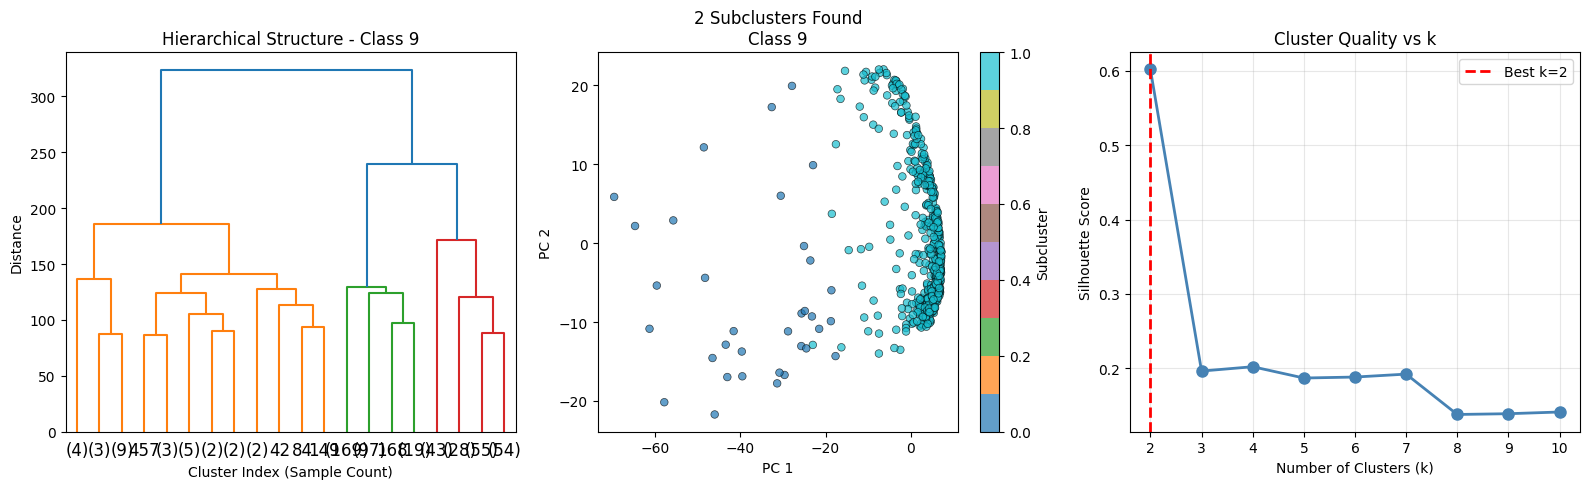

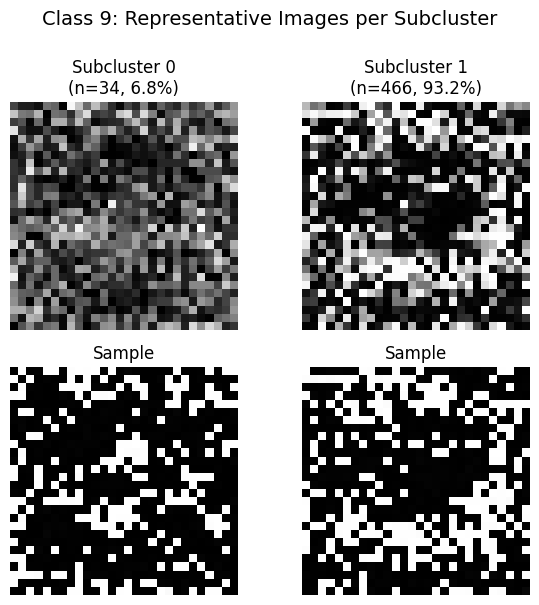

In [53]:
target_class = 9
each_number_samples = 500
X_0, y = create_custom_batch(key,
                    numbers = [target_class],
                    each_number_samples=each_number_samples)

# Step 1: Integrate (if you haven't already)
print("Step 1: Integrating dataset...")
X_T = integrate_over_dataset(best_model, X_0, args.dt, args.t1)
print(f"✓ Integration complete. X_T shape: {X_T.shape}")

# Step 2: Analyze a single class
print("\n" + "="*60)
print("Step 2: Clustering Analysis")
print("="*60)

results = find_subclusters(X_T, y, target_class, n_samples=each_number_samples)
visualize_subclusters(results)

In [56]:
each_number_samples = 500
X_0, y = create_custom_batch(key,
                    numbers = [0,1,2,3,4,5,6,7,8,9],
                    each_number_samples=each_number_samples)


X_T = integrate_over_dataset(best_model, X_0, args.dt, args.t1)

Integrating samples:   0%|          | 0/5000 [00:00<?, ?it/s]

In [57]:
                   
# Step 3: (Optional) Analyze all classes
def analyze_all_classes(X_T, y, n_samples=500):
    """Analyze all 10 digits."""
    summary = []
    
    for digit in range(10):
        print(f"\n{'='*60}")
        print(f"DIGIT {digit}")
        print('='*60)
        
        results = find_subclusters(X_T, y, digit, n_samples)
        visualize_subclusters(results)
        
        summary.append({
            'digit': digit,
            'n_subclusters': results['best_k'],
            'silhouette': results['best_score']
        })
    
    # Print summary table
    print("\n" + "="*60)
    print("SUMMARY: Subclusters Found in Each Digit Class")
    print("="*60)
    print(f"{'Digit':<10} {'Subclusters':<15} {'Silhouette':<15}")
    print("-"*60)
    for s in summary:
        print(f"{s['digit']:<10} {s['n_subclusters']:<15} {s['silhouette']:<15.3f}")
    
    return summary

# Run full analysis (optional)
# summary = analyze_all_classes(X_T, y, n_samples=500)


DIGIT 0

Analyzing class 0: 500 samples


PCA explained variance (50D): 0.901

Testing different numbers of clusters...
  k=2: silhouette=0.685
  k=3: silhouette=0.674
  k=4: silhouette=0.252
  k=5: silhouette=0.255
  k=6: silhouette=0.256
  k=7: silhouette=0.257
  k=8: silhouette=0.261
  k=9: silhouette=0.265
  k=10: silhouette=0.267

✓ Optimal: 2 subclusters (silhouette=0.685)


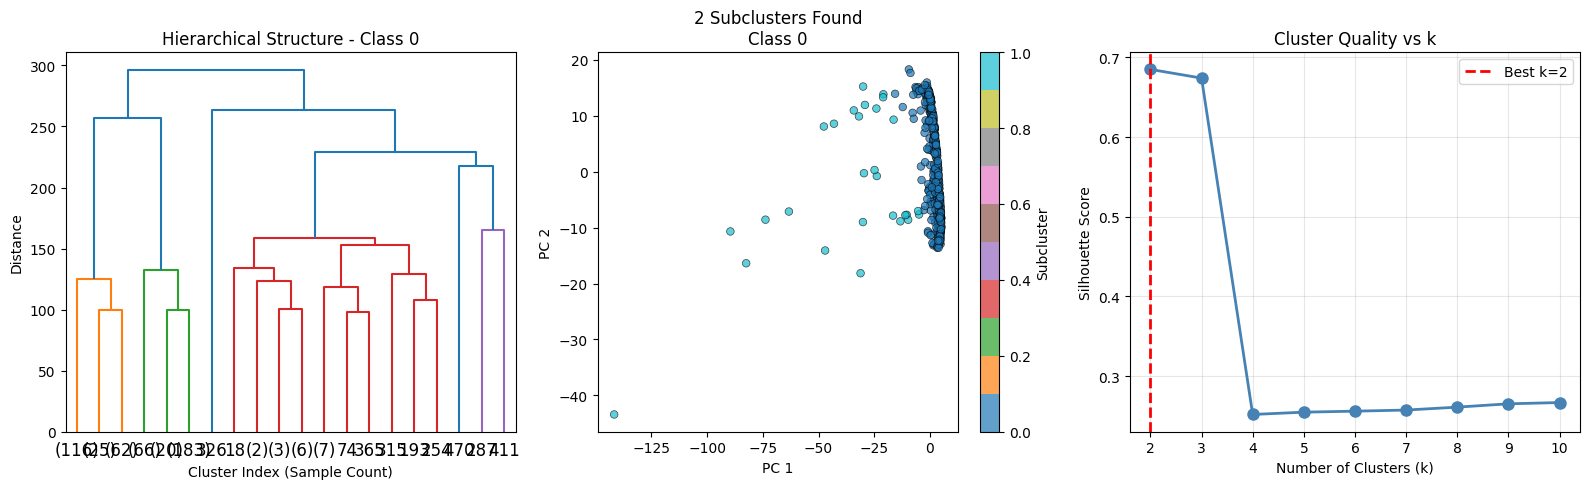

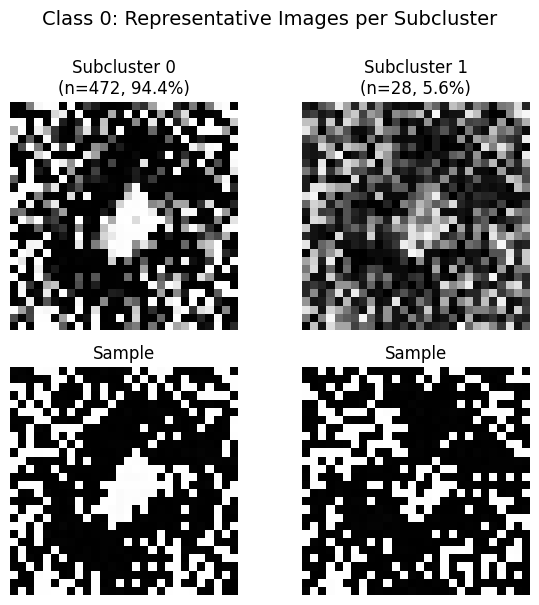


DIGIT 1

Analyzing class 1: 500 samples
PCA explained variance (50D): 0.877

Testing different numbers of clusters...
  k=2: silhouette=0.260
  k=3: silhouette=0.252
  k=4: silhouette=0.263
  k=5: silhouette=0.238
  k=6: silhouette=0.251
  k=7: silhouette=0.220
  k=8: silhouette=0.226
  k=9: silhouette=0.228
  k=10: silhouette=0.231

✓ Optimal: 4 subclusters (silhouette=0.263)


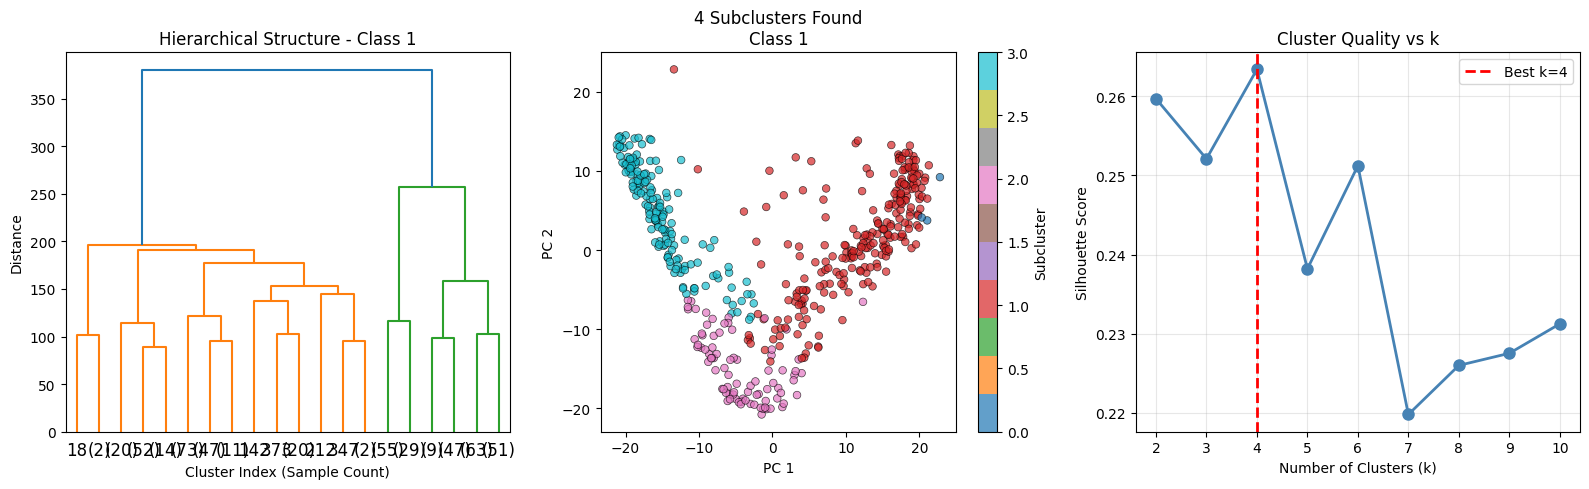

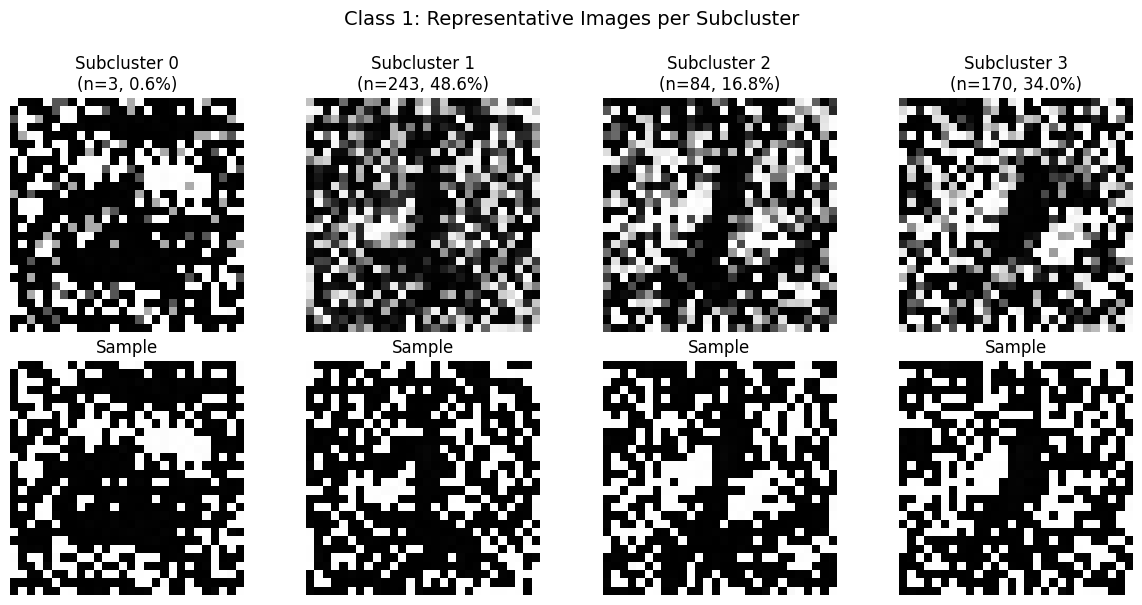


DIGIT 2

Analyzing class 2: 500 samples
PCA explained variance (50D): 0.823

Testing different numbers of clusters...
  k=2: silhouette=0.199
  k=3: silhouette=0.199
  k=4: silhouette=0.187
  k=5: silhouette=0.201
  k=6: silhouette=0.204
  k=7: silhouette=0.208
  k=8: silhouette=0.212
  k=9: silhouette=0.215
  k=10: silhouette=0.178

✓ Optimal: 9 subclusters (silhouette=0.215)


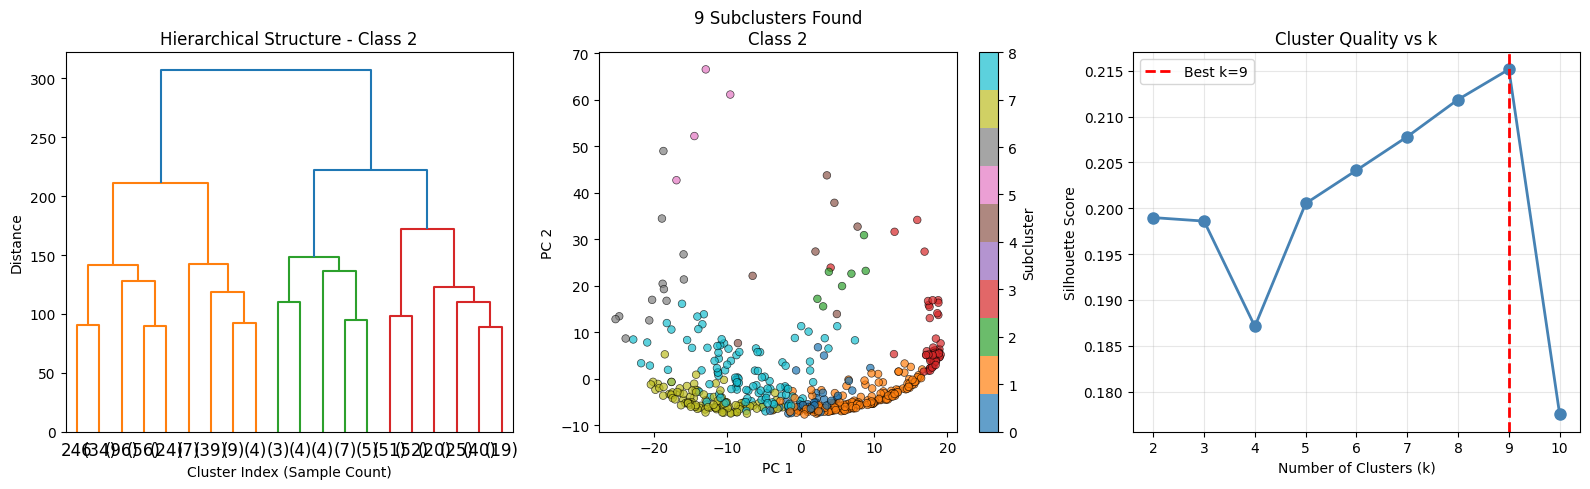

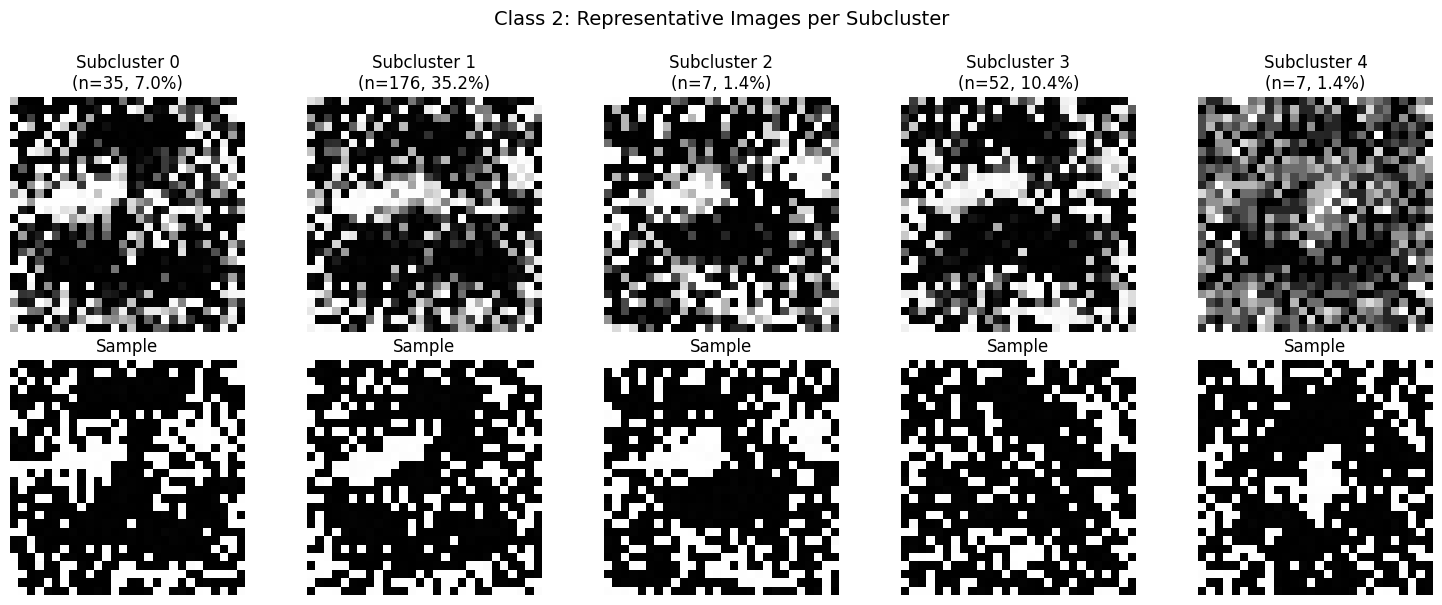


DIGIT 3

Analyzing class 3: 500 samples
PCA explained variance (50D): 0.855

Testing different numbers of clusters...
  k=2: silhouette=0.239
  k=3: silhouette=0.240
  k=4: silhouette=0.259
  k=5: silhouette=0.287
  k=6: silhouette=0.215
  k=7: silhouette=0.218
  k=8: silhouette=0.220
  k=9: silhouette=0.232
  k=10: silhouette=0.234

✓ Optimal: 5 subclusters (silhouette=0.287)


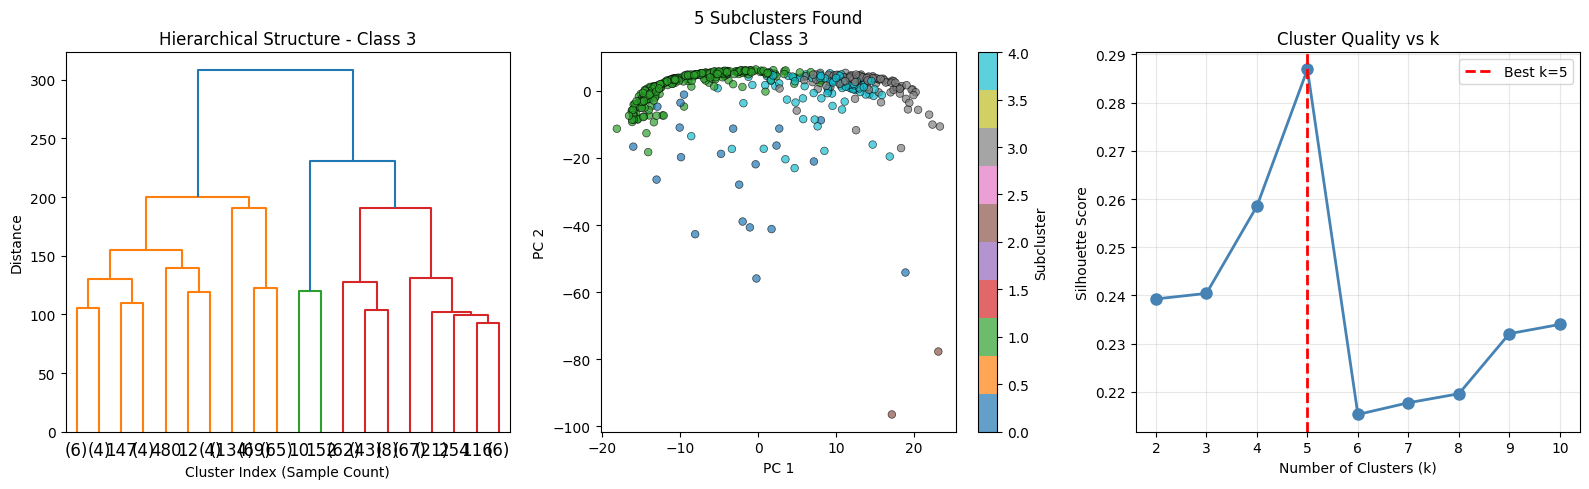

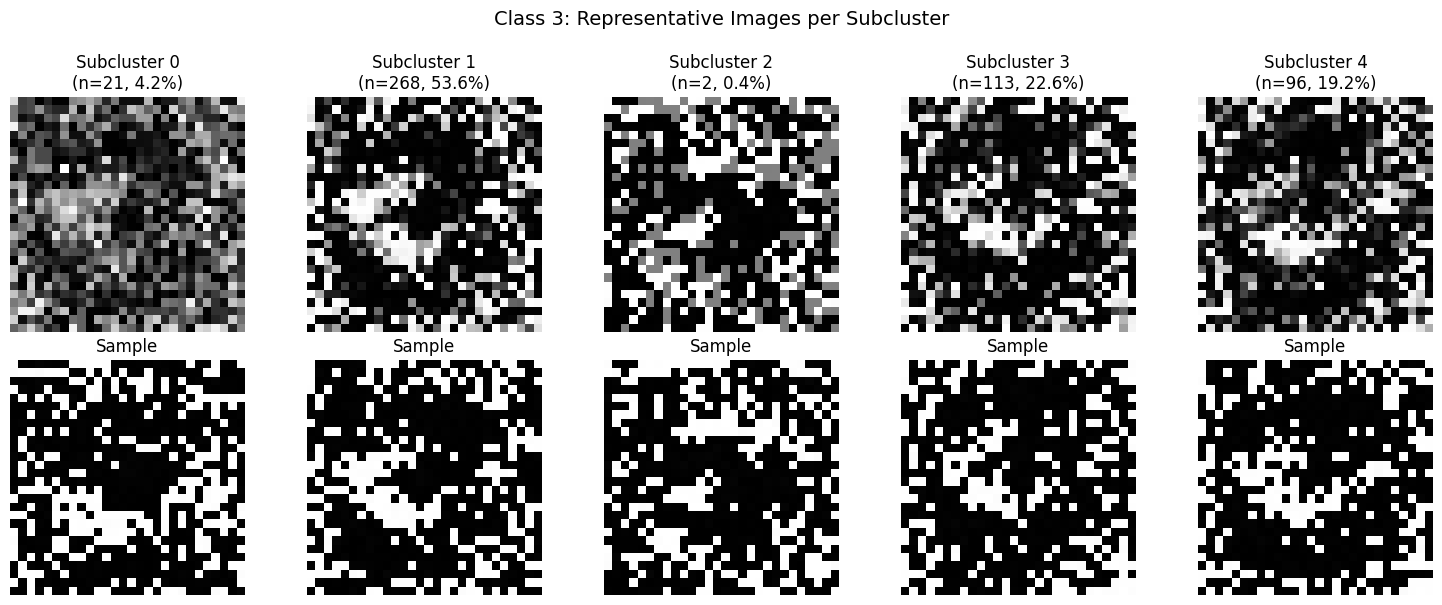


DIGIT 4

Analyzing class 4: 500 samples
PCA explained variance (50D): 0.843

Testing different numbers of clusters...
  k=2: silhouette=0.388
  k=3: silhouette=0.380
  k=4: silhouette=0.388
  k=5: silhouette=0.169
  k=6: silhouette=0.173
  k=7: silhouette=0.189
  k=8: silhouette=0.193
  k=9: silhouette=0.200
  k=10: silhouette=0.218

✓ Optimal: 2 subclusters (silhouette=0.388)


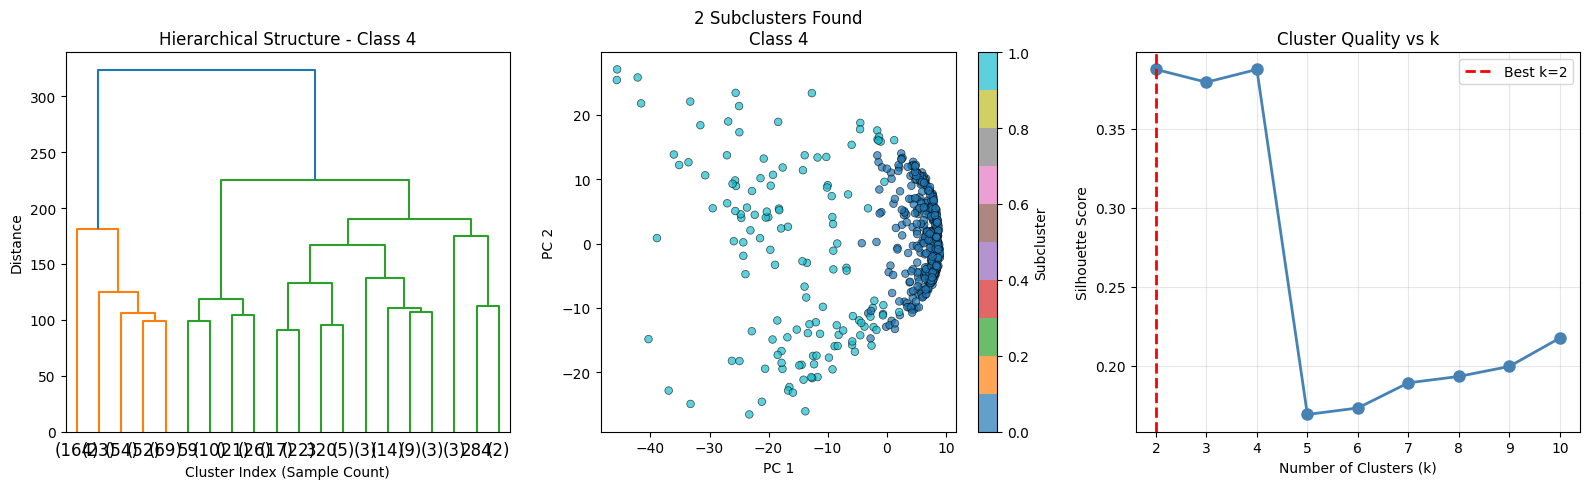

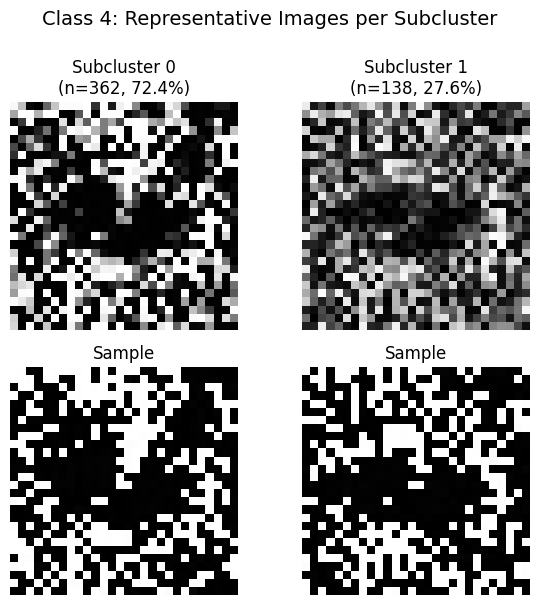


DIGIT 5

Analyzing class 5: 500 samples
PCA explained variance (50D): 0.815

Testing different numbers of clusters...
  k=2: silhouette=0.255
  k=3: silhouette=0.274
  k=4: silhouette=0.274
  k=5: silhouette=0.287
  k=6: silhouette=0.295
  k=7: silhouette=0.155
  k=8: silhouette=0.166
  k=9: silhouette=0.173
  k=10: silhouette=0.179

✓ Optimal: 6 subclusters (silhouette=0.295)


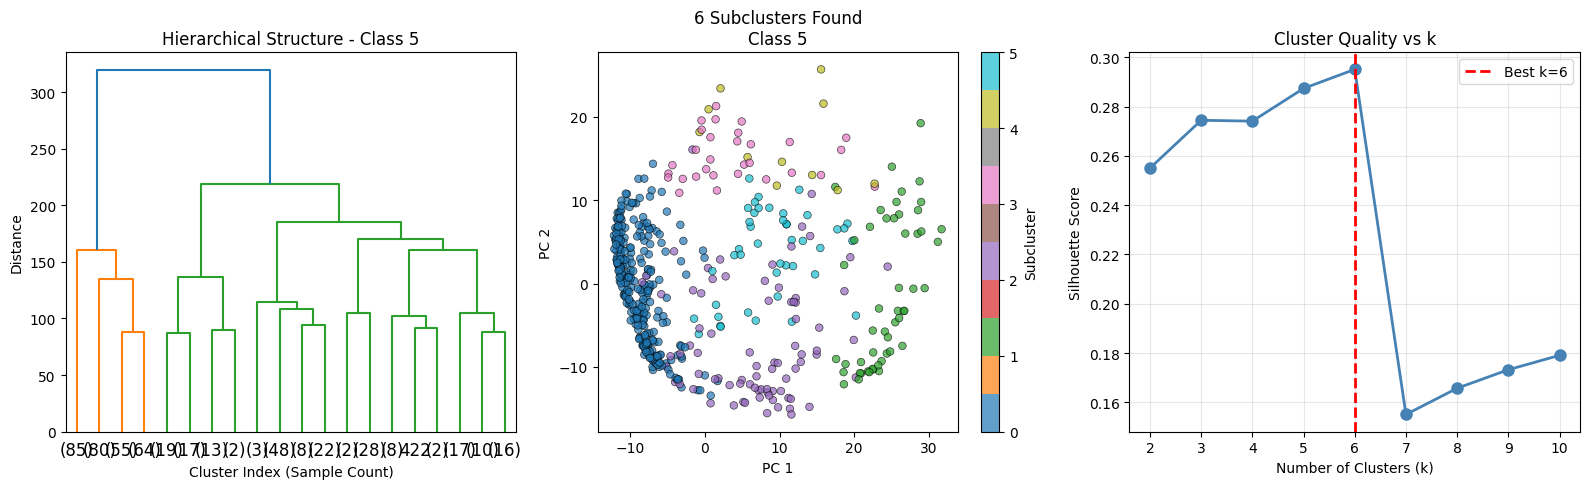

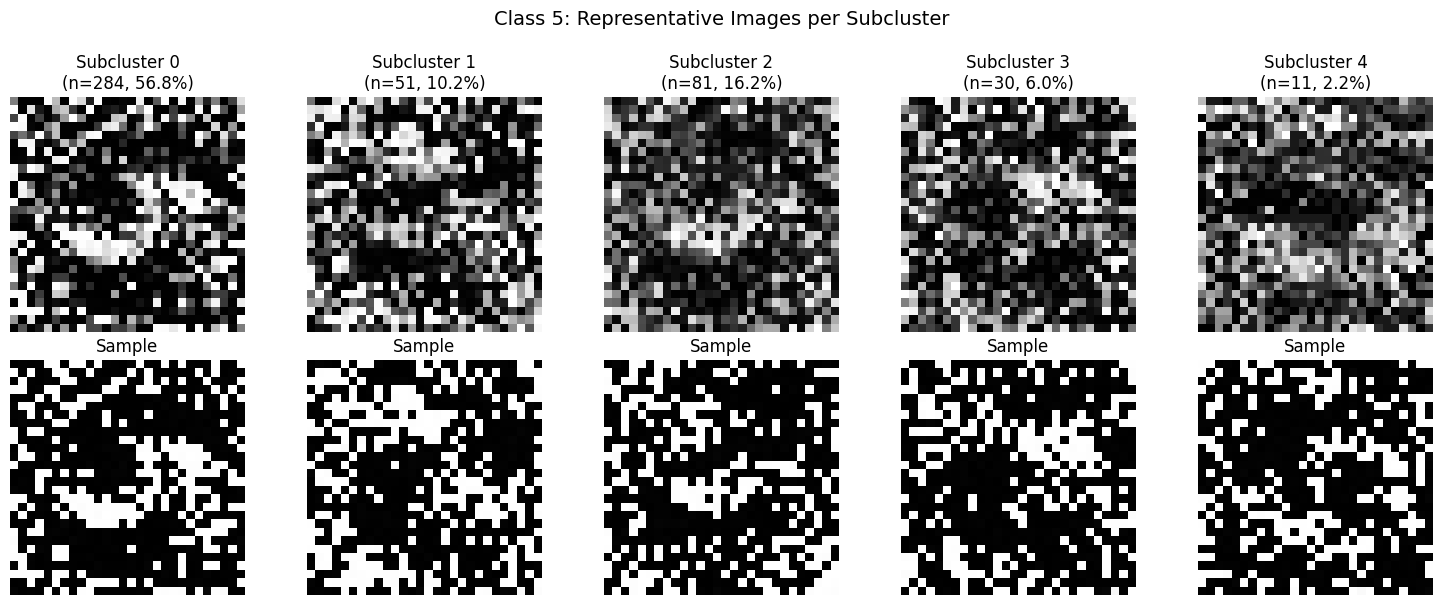


DIGIT 6

Analyzing class 6: 500 samples
PCA explained variance (50D): 0.878

Testing different numbers of clusters...
  k=2: silhouette=0.550
  k=3: silhouette=0.532
  k=4: silhouette=0.535
  k=5: silhouette=0.188
  k=6: silhouette=0.190
  k=7: silhouette=0.196
  k=8: silhouette=0.210
  k=9: silhouette=0.219
  k=10: silhouette=0.220

✓ Optimal: 2 subclusters (silhouette=0.550)


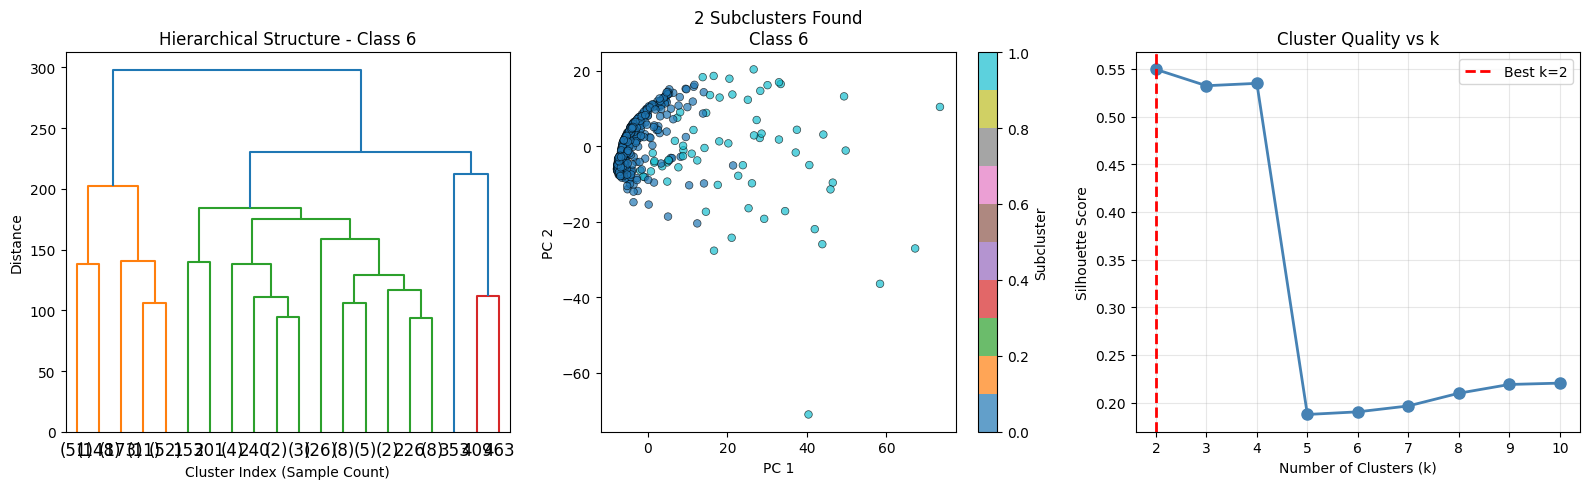

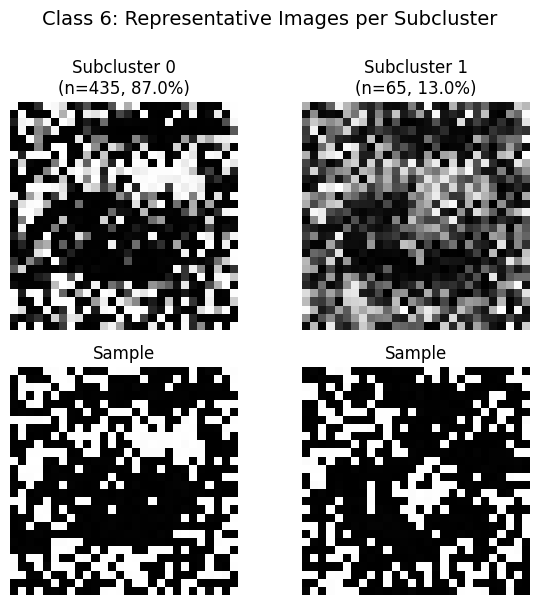


DIGIT 7

Analyzing class 7: 500 samples
PCA explained variance (50D): 0.850

Testing different numbers of clusters...
  k=2: silhouette=0.209
  k=3: silhouette=0.187
  k=4: silhouette=0.204
  k=5: silhouette=0.212
  k=6: silhouette=0.188
  k=7: silhouette=0.210
  k=8: silhouette=0.183
  k=9: silhouette=0.184
  k=10: silhouette=0.198

✓ Optimal: 5 subclusters (silhouette=0.212)


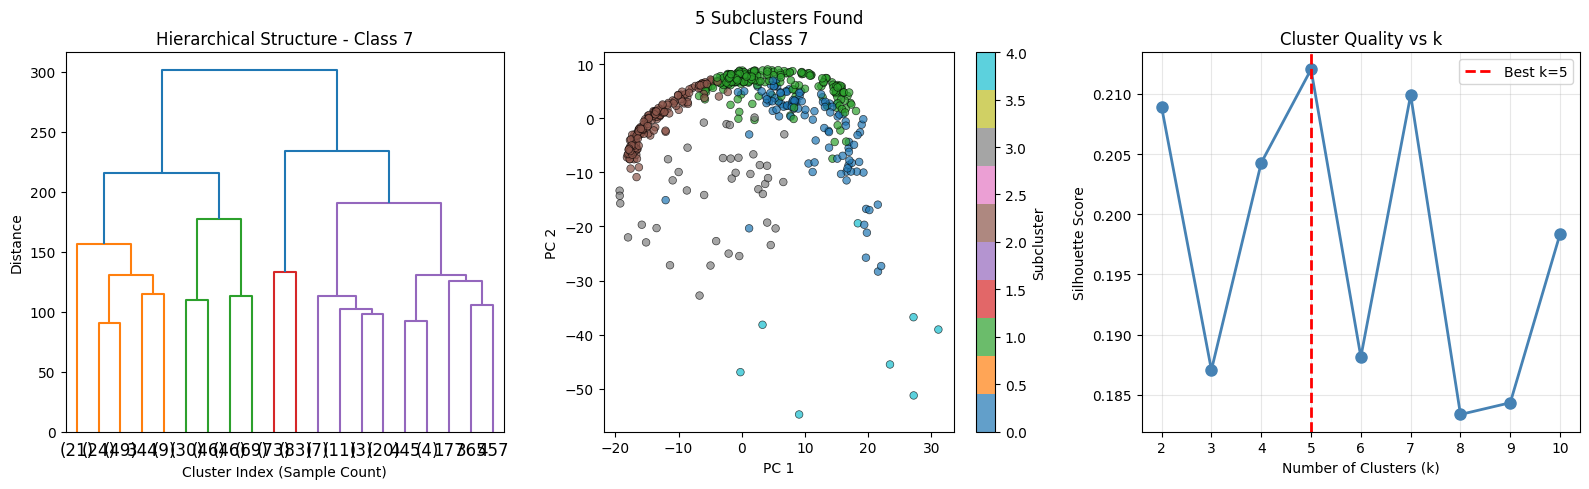

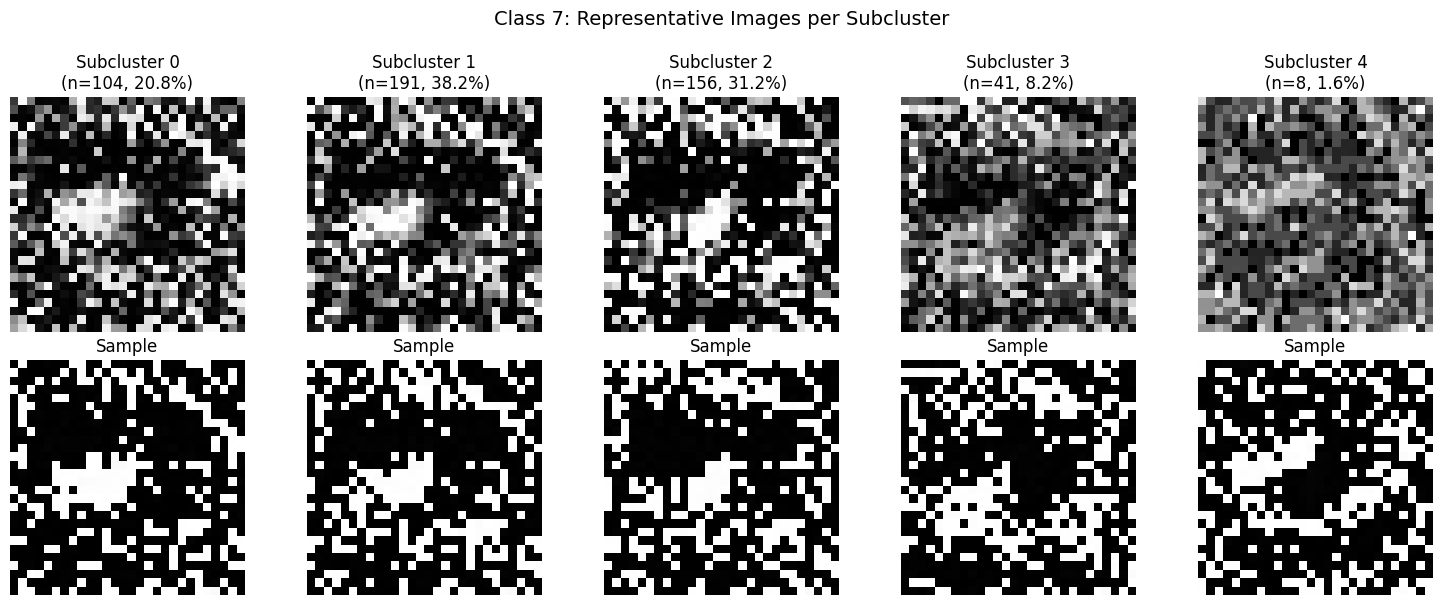


DIGIT 8

Analyzing class 8: 500 samples
PCA explained variance (50D): 0.852

Testing different numbers of clusters...
  k=2: silhouette=0.448
  k=3: silhouette=0.436
  k=4: silhouette=0.408
  k=5: silhouette=0.410
  k=6: silhouette=0.291
  k=7: silhouette=0.307
  k=8: silhouette=0.308
  k=9: silhouette=0.309
  k=10: silhouette=0.312

✓ Optimal: 2 subclusters (silhouette=0.448)


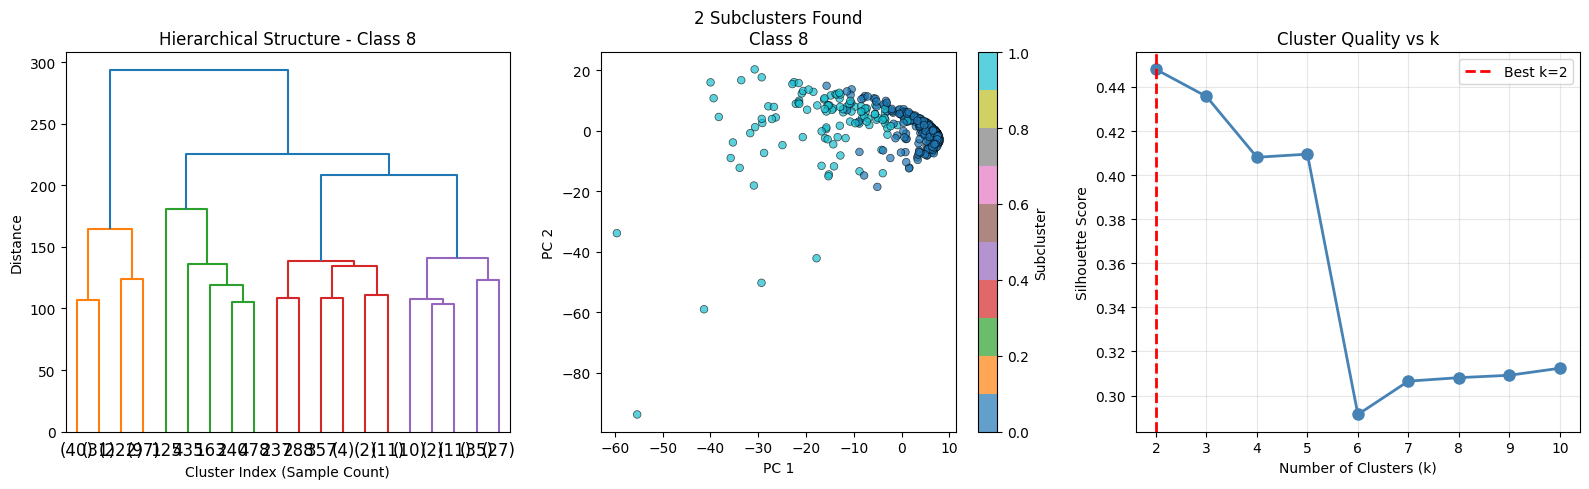

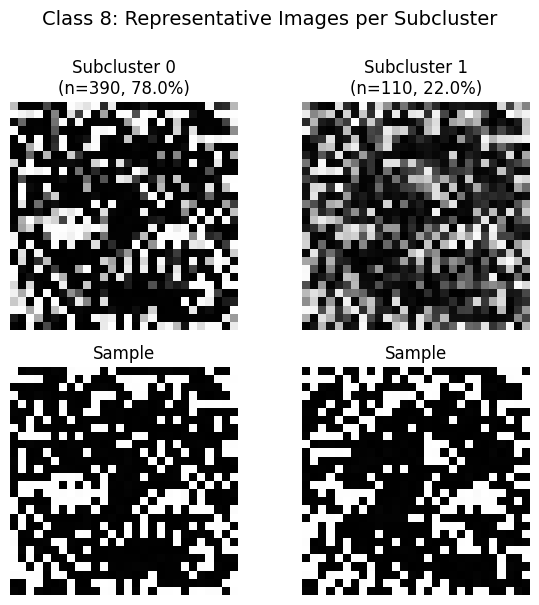


DIGIT 9

Analyzing class 9: 500 samples
PCA explained variance (50D): 0.830

Testing different numbers of clusters...
  k=2: silhouette=0.511
  k=3: silhouette=0.217
  k=4: silhouette=0.223
  k=5: silhouette=0.207
  k=6: silhouette=0.192
  k=7: silhouette=0.199
  k=8: silhouette=0.201
  k=9: silhouette=0.207
  k=10: silhouette=0.209

✓ Optimal: 2 subclusters (silhouette=0.511)


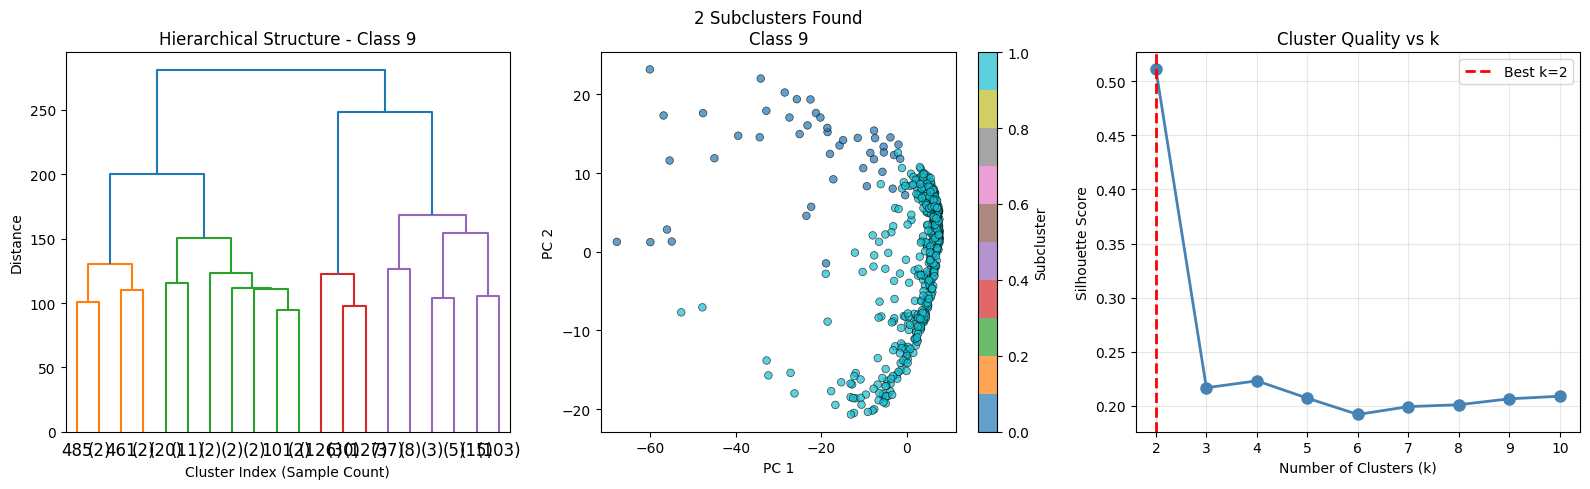

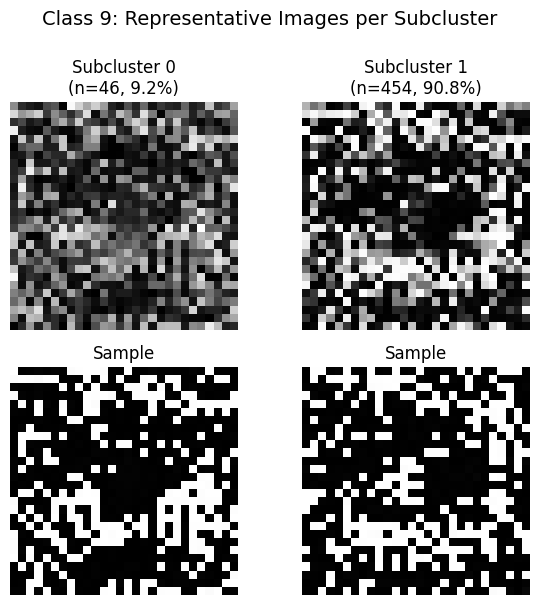


SUMMARY: Subclusters Found in Each Digit Class
Digit      Subclusters     Silhouette     
------------------------------------------------------------
0          2               0.685          
1          4               0.263          
2          9               0.215          
3          5               0.287          
4          2               0.388          
5          6               0.295          
6          2               0.550          
7          5               0.212          
8          2               0.448          
9          2               0.511          


In [58]:
summary = analyze_all_classes(X_T, y, n_samples=500)